# Cross-Validation for Time Series

How to cross validate time series? There are serveral options - and none is perfect.

**Walk-Forward Validation**

Pros:
- No look-ahead bias
- Easy to use with sequential models (e.g., STD and RNN)

Cons:
- It cannot evaluate the earliest period of the history
- A pessimistic estimate bias because the size of the training set is growing over time

**Mowing-origin Forward Validation**

Pros (w.r.t. Walk-Forward Validation):
- The more recent data is evaluated more, so its contribution to the overall result is higher

Cons (w.r.t. Walk-Forward Validation):
- A more pessimistic estimate bias because almost half of the folds have a validation set bigger than a training set, which is unlikely to produce a robust estimate

**Blocked K-Fold Cross-Validation**

Pros:
- The same amount of data points in every training set
- It can evaluate the earliest period of the history

Cons:
- A (possibly) optimistic look-ahead bias

**Combinatorial Cross-Validation**

Pros (w.r.t. Blocked K-Fold Cross-Validation):
- It generates several backtest paths rather than one

Cons (w.r.t. Blocked K-Fold Cross-Validation):
- A few times more computationally expensive

**Note:** This notebooks demonstrates that time series nonstationarity may have a direct impact on the effectiveness of model evaluation. There exist many methods to reduce time series nonstationarity (notably, by removing a trend and a seasonal pattern) but these methods are outside of the scope of this notebook.

## Setup

In [1]:
import datetime as dt
import itertools
import sys
import warnings
from collections import defaultdict
from functools import partial
from typing import Callable, Optional, Sequence

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from loguru import logger
from numba import njit

import shap
from sklearn.base import RegressorMixin, BaseEstimator
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import HistGradientBoostingClassifier, GradientBoostingRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold, GridSearchCV, train_test_split, cross_validate
from sklearn.inspection import permutation_importance
from lightgbm import LGBMRegressor, early_stopping
from scipy.stats import norm

np.random.seed(42**3)

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
logger.remove()
logger.add(sys.stderr, format='{time} {level} {line}: {message}', level='DEBUG')

plt.style.use('seaborn')
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['figure.figsize'] = (5, 5)
plt.rcParams['font.family'] = 'monospace'

np.set_printoptions(
    edgeitems=30,
    linewidth=10000,
    precision=3,
    formatter={"float": lambda x: f"{x:.3f}"}
)
pd.options.display.precision = 3
pd.options.display.max_rows = 200
pd.options.display.max_columns = 80
pd.options.display.max_colwidth = 100

In [3]:
def ht(df, n=2):
    display(pd.concat([df.head(n), df.tail(n)]))

## Custom Models

In [4]:
class LGBMRegressorEarlyStop(BaseEstimator, RegressorMixin):
    """LGBMRegressor with Early Stopping."""
    
    def __init__(
        self,
        regressor=LGBMRegressor(),
        eval_ratio: float = .2,
        eval_metric: str = "l2",
        stopping_rounds: int = 5,
        min_delta: float = 0.,
    ):
        assert 0 < eval_ratio < 1
        self.regressor = regressor
        self.eval_ratio = eval_ratio
        self.eval_metric = eval_metric
        self.stopping_rounds = stopping_rounds
        self.min_delta = min_delta
        
    def fit(self, X, y, **kwargs):
        assert kwargs.get("eval_set") is None
        assert kwargs.get("eval_metric") is None
        assert kwargs.get("callbacks") is None
        assert len(X) == len(y)
        i_split = int(len(y) * (1. - self.eval_ratio))
        es_callback = early_stopping(
            stopping_rounds=self.stopping_rounds, min_delta=self.min_delta, verbose=False,
        )
        _ = self.regressor.fit(
            X[:i_split],
            y[:i_split],
            eval_set=(X[i_split:], y[i_split:]),
            eval_metric=self.eval_metric,
            callbacks=[es_callback],
            **kwargs
        )
        return self
    
    def predict(self, X, **kwargs):
        return self.regressor.predict(X, **kwargs)
        

## Time Series Generation Functions

Text(0.5, 0.98, 'Gaussian walk')

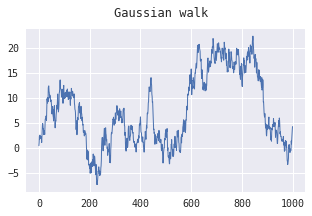

In [5]:
def gaussian_process_data(size: int, stdev: float = 1.):
    """Gausian walk process"""
    
    deltas = np.random.normal(size=size, scale=stdev)
    series = np.cumsum(deltas)
    return series


plt.subplots(1, 1, figsize=(5, 3))
plt.plot(gaussian_process_data(1000))
plt.suptitle("Gaussian walk")

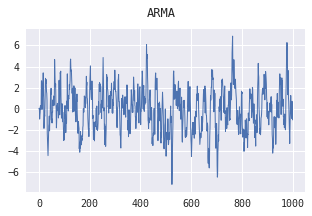

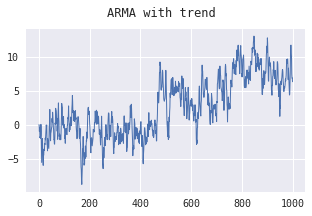

In [6]:
def arma_process_data(
    size: int,
    ar_params: Sequence[float] = (0.5, 0.25),
    ma_params: Sequence[float] = (0.5, 0.25),
    stdev: float = 1.,
    trend_magnitude: float = 0., 
    trend_rate: float = 0.,
    verbose: bool = False,
):
    """ARMA process"""
    
    ar_params = np.asarray(ar_params)
    ma_params = np.asarray(ma_params)
    assert np.sum(ar_params ** 2) < 1
    p = len(ar_params)
    q = len(ma_params)
    series = np.zeros(size)
    noise = np.random.normal(size=size, scale=stdev)
    trend_abs = trend_magnitude / size
    trend_proba = trend_rate / size
    assert 0 <= trend_proba <= 1
    trend = 0
    
    for i in range(max(p, q), size):
        ar_sum = np.dot(series[i-p:i][::-1], ar_params)
        ma_sum = np.dot(noise[i-q:i][::-1], ma_params)
        series[i] = trend + ar_sum + ma_sum + noise[i]
        if np.random.random() < trend_proba:
            trend += trend_abs * np.random.choice((-1, 1))
            if verbose:
                logger.debug(f"trend changed i={i} new={trend:.2f}")

    return series

plt.subplots(1, 1, figsize=(5, 3))
plt.plot(arma_process_data(1000))
plt.suptitle("ARMA")

plt.subplots(1, 1, figsize=(5, 3))
plt.plot(arma_process_data(1000, trend_magnitude=1000., trend_rate=5.))
plt.suptitle("ARMA with trend")
_ = _

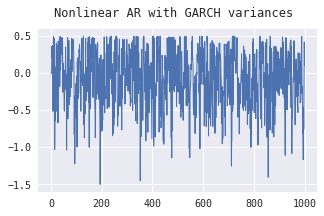

In [7]:
def ar_garch_process_data(
    size: int,
    transformation: Callable,
    ar_params: Sequence[float] = (0.2, 0.3, 0.1, -0.2),
    garch_ar_params: Sequence[float] = (0.25, 0.25),
    garch_ma_params: Sequence[float] = (0.25, 0.25),
    stdev: float = 0.5,
    trend_magnitude: float = 0., 
    trend_rate: float = 0.,
    garch_kwargs: Optional[dict] = None,
    verbose: bool = True,
):
    """AR-GARCH process"""

    ar_params = np.asarray(ar_params)
    garch_ar_params = np.asarray(garch_ar_params)
    garch_ma_params = np.asarray(garch_ma_params)
    
    assert np.sum(ar_params ** 2) < 1
    
    noise = np.random.normal(size=size, scale=stdev)
    
    p = len(ar_params)
    series = np.zeros(size)
    evs = np.zeros(size)
    garch_p = len(garch_ar_params)
    garch_q = len(garch_ma_params)
    vols = np.full(size, 1.)
    
    trend_abs = trend_magnitude / size
    trend_proba = trend_rate / size
    assert 0 <= trend_proba <= 1
    trend = 0
    
    for i in range(max(p, garch_p, garch_q), size):
        garch_ar_sum = np.dot(vols[i-garch_p:i][::-1] ** 2, garch_ar_params)
        garch_ma_sum = np.dot(evs[i-garch_q:i][::-1] ** 2, garch_ma_params)
        vols[i] = np.sqrt(stdev ** 2 + garch_ar_sum + garch_ma_sum)
        evs[i] = noise[i] * vols[i]
        ar_sum = np.dot(series[i-p:i][::-1], ar_params)
        series[i] = transformation(trend + ar_sum + evs[i])
        if np.random.random() < trend_proba:
            trend += trend_abs * np.random.choice((-1, 1))
            if verbose:
                logger.debug(f"trend changed i={i} new={trend:.2f}")
        
    return series


def nonlinear_sin(x, pos_factor: float = 0.5, neg_factor: float = 10.):
    return (
        pos_factor * np.sin(x/pos_factor) * (x > 0) + 
        neg_factor * np.sin(x/neg_factor) * (x < 0)
    )

plt.subplots(1, 1, figsize=(5, 3))
plt.plot(ar_garch_process_data(1000, nonlinear_sin))
plt.suptitle("Nonlinear AR with GARCH variances")
_=_

## Time Series Stationarity

In [8]:
def ts_mean_covariance(gen_fun, size: int, n_paths: int, n_covar: int = 1):
    paths = np.empty((size, n_paths))
    for i in range(n_paths):
        paths[:, i] = gen_fun(size=size)

    means = np.mean(paths, axis=1)
    assert len(means) == size
    plt.subplots(1, 1, figsize=(5, 2))
    plt.plot(means)
    plt.suptitle(f"Process mean {n_paths=}")

    paths = paths - means[:, np.newaxis]
    var = np.mean(paths ** 2, axis=1)
    assert len(var) == size
    plt.subplots(1, 1, figsize=(5, 2))
    plt.plot(var)
    plt.suptitle(f"Process var {n_paths=}")
    
    for h in range(1, n_covar + 1):
        covar = np.mean(paths[h:] * paths[:-h], axis=1)
        assert len(covar) == size - h
        plt.subplots(1, 1, figsize=(5, 2))
        plt.plot(covar)
        plt.suptitle(f"Process covar h={h} {n_paths=}")

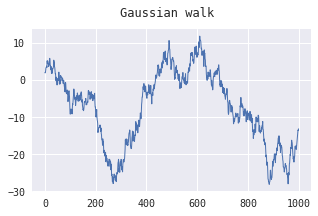

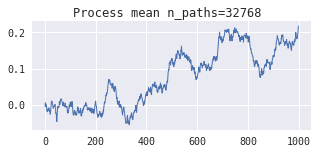

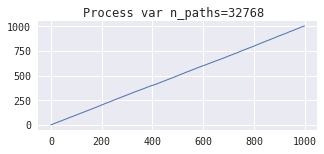

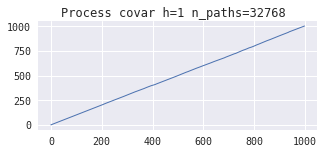

In [9]:
plt.subplots(1, 1, figsize=(5, 3))
plt.plot(gaussian_process_data(1000))
plt.suptitle("Gaussian walk")

ts_mean_covariance(gaussian_process_data, 1000, 2**15)

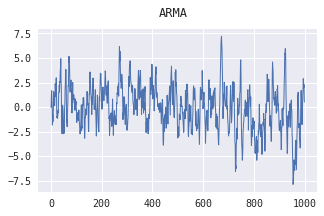

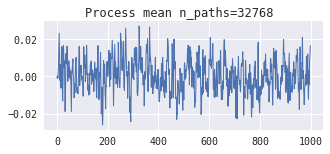

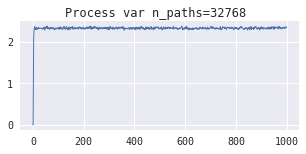

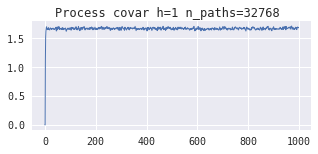

In [10]:
@njit
def arma_process_data_fast(
    size: int,
    ar_params: Sequence[float] = (0.5, 0.25),
    ma_params: Sequence[float] = (0.5, 0.25),
    stdev: float = 1.,
    trend_magnitude: float = 0., 
    trend_rate: float = 0.,
    verbose: bool = False,
):
    """ARMA process (accelerated)"""
    
    assert np.sum(np.asarray(ar_params) ** 2) < 1
    ar_params = np.asarray(ar_params)
    ma_params = np.asarray(ma_params)
    p = len(ar_params)
    q = len(ma_params)
    series = np.zeros(size)
    noise = np.empty(size)
    for i in range(size):
        noise[i] = np.random.normal(loc=0, scale=stdev)
    trend_abs = trend_magnitude / size
    trend_proba = trend_rate / size
    assert 0 <= trend_proba <= 1
    trend = 0
    
    trend_directions = np.array((-1, 1))
    for i in range(max(p, q), size):
        ar_sum = np.multiply(series[i-p:i][::-1], ar_params)[0]
        ma_sum = np.multiply(noise[i-q:i][::-1], ma_params)[0]
        series[i] = trend + ar_sum + ma_sum + noise[i]
        if np.random.random() < trend_proba:
            trend += trend_abs * np.random.choice(a=trend_directions)
            if verbose:
                print("trend changed ", i, trend)

    return series

plt.subplots(1, 1, figsize=(5, 3))
plt.plot(arma_process_data(1000))
plt.suptitle("ARMA")

ts_mean_covariance(arma_process_data_fast, 1000, 2**15)

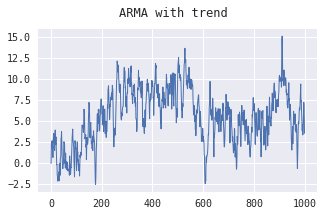

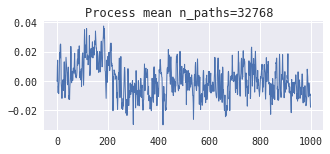

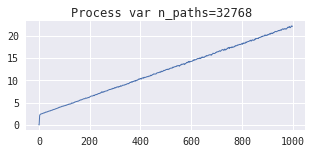

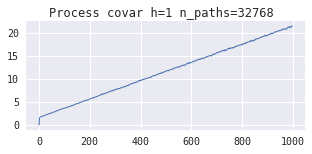

In [11]:
plt.subplots(1, 1, figsize=(5, 3))
plt.plot(arma_process_data(1000, trend_magnitude=1000., trend_rate=5.))
plt.suptitle("ARMA with trend")
_ = _

ts_mean_covariance(
    partial(arma_process_data_fast, trend_magnitude=1000., trend_rate=5., verbose=False), 1000, 2**15
)

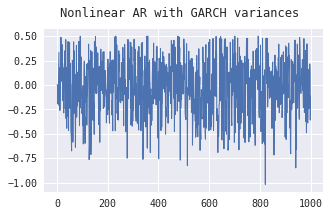

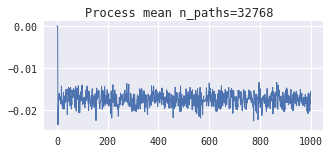

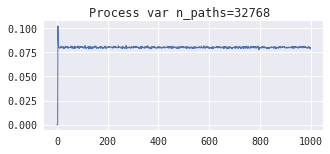

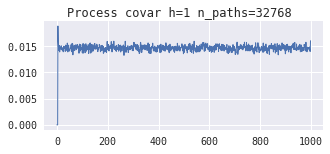

In [12]:
@njit
def ar_garch_process_data_fast(
    size: int,
    transformation: Callable,
    ar_params: Sequence[float] = (0.2, 0.3, 0.1, -0.2),
    garch_ar_params: Sequence[float] = (0.25, 0.25),
    garch_ma_params: Sequence[float] = (0.25, 0.25),
    stdev: float = 0.5,
    trend_magnitude: float = 0., 
    trend_rate: float = 0.,
    garch_kwargs: Optional[dict] = None,
    verbose: bool = True,
):
    """AR-GARCH process"""

    ar_params = np.asarray(ar_params)
    garch_ar_params = np.asarray(garch_ar_params)
    garch_ma_params = np.asarray(garch_ma_params)
    
    assert np.sum(ar_params ** 2) < 1
    
    noise = np.empty(size)
    for i in range(size):
        noise[i] = np.random.normal(loc=0, scale=stdev)
    
    p = len(ar_params)
    series = np.zeros(size)
    evs = np.zeros(size)
    garch_p = len(garch_ar_params)
    garch_q = len(garch_ma_params)
    vols = np.full(size, 1.)
    
    trend_abs = trend_magnitude / size
    trend_proba = trend_rate / size
    assert 0 <= trend_proba <= 1
    trend = 0

    trend_directions = np.array((-1, 1))
    for i in range(max(p, garch_p, garch_q), size):
        garch_ar_sum = np.multiply(vols[i-garch_p:i][::-1] ** 2, garch_ar_params)[0]
        garch_ma_sum = np.multiply(evs[i-garch_q:i][::-1] ** 2, garch_ma_params)[0]
        vols[i] = np.sqrt(stdev ** 2 + garch_ar_sum + garch_ma_sum)
        evs[i] = noise[i] * vols[i]
        ar_sum = np.multiply(series[i-p:i][::-1], ar_params)[0]
        series[i] = transformation(trend + ar_sum + evs[i])
        if np.random.random() < trend_proba:
            trend += trend_abs * np.random.choice(trend_directions)
            if verbose:
                print("trend changed ", i, trend)
        
    return series


@njit
def nonlinear_sin_fast(x, pos_factor: float = 0.5, neg_factor: float = 10.):
    return (
        pos_factor * np.sin(x/pos_factor) * (x > 0) + 
        neg_factor * np.sin(x/neg_factor) * (x < 0)
    )


plt.subplots(1, 1, figsize=(5, 3))
plt.plot(ar_garch_process_data_fast(1000, nonlinear_sin_fast))
plt.suptitle("Nonlinear AR with GARCH variances")

ts_mean_covariance(
    partial(ar_garch_process_data_fast, transformation=nonlinear_sin_fast), 1000, 2**15
)
_=_

## Validation Functions

In [13]:
def walk_forward(
    X,
    y,
    m,
    k_folds,
    unbounded_fold: bool = False,
    only_last_fold: bool = False,
    n_warmup: int = 0,
    verbose: bool = True,
):
    """Walk-forward validation
    
    Args:
        unlimited_test_window: if True, the test sets are unbounded from the right
            - True = moving origin walk-forward validation
            - False = blocked walk-forward validation
        only_last_fold: if True, only the last fold is tested
            - True = single-split (a.k.a. last block) validation
            - False = walk-forward validation
    """
    
    assert not (unbounded_fold and only_last_fold)
    n_points = len(y)
    if unbounded_fold:
        fold_indices = {
            k: (
                n_warmup + int(n_points * k  / k_folds),
                n_warmup + n_points,
            )
            for k in range(k_folds)
        }
    else:
        fold_indices = {
            k: (
                n_warmup + int(n_points * k  / k_folds),
                n_warmup + int(n_points * (k + 1) / k_folds),
            )
            for k in range(k_folds)
        }
    mae_test = {}
    mse_test = {}
    y_test_hat_all = {}
    first_fold = k_folds - 1 if only_last_fold else 0
    for k in range(first_fold, k_folds):
        i_split_0, i_split_1 = fold_indices[k]
        if (n_warmup == 0) and (k == 0):
            mae_test[k] = np.nan
            coef = None
            y_test_hat = np.full(i_split_1, np.nan)
        else:
            y_train = y[: i_split_0]
            x_train = X[: i_split_0]
            y_test = y[i_split_0: i_split_1]
            x_test = X[i_split_0: i_split_1]

            m.fit(x_train, y_train)
            y_test_hat = m.predict(x_test)
            mae_test[k] = np.mean(np.abs(y_test - y_test_hat))
            mse_test[k] = np.mean((y_test - y_test_hat) ** 2)
            coef = m.coef_ if hasattr(m, "coef_") else None
        if verbose:
            logger.debug(f"fold={k} coef={coef} mae_test={mae_test[k]:.3f}")
            y_test_hat_all[k] = y_test_hat
    if verbose:
        fig, ax = plt.subplots(1, 1, figsize=(10, 3))
        plt.plot(y, label="true")
        if unbounded_fold:
            for k, y_test_hat in y_test_hat_all.items():
                if not np.all(np.isnan(y_test_hat)):
                    i_split_0, i_split_1 = fold_indices[k]
                    plt.plot(
                        range(i_split_0, i_split_1), y_test_hat_all[k], alpha=0.7, label=f"predicted={k}"
                    )
            validation_title = "Moving-origin Forward validation"
        elif only_last_fold:
            assert len(y_test_hat_all) == 1
            i_split_0, i_split_1 = fold_indices[first_fold]
            plt.plot(
                range(i_split_0, i_split_1), y_test_hat_all[first_fold], alpha=0.7, label="predicted"
            )
            validation_title = "Last-block validation"
        else:
            plt.plot(np.concatenate(list(y_test_hat_all.values())), alpha=0.7, label="predicted")
            validation_title = "Walk-forward validation"
        for i_split_0, i_split_1 in fold_indices.values():
            plt.axvline(i_split_0, linestyle="--", color="gray", alpha=0.5)
            plt.axvline(i_split_1, linestyle="--", color="gray", alpha=0.5)
        plt.legend()
        plt.suptitle(f"{validation_title}: Paths")
    return mae_test, mse_test

In [14]:
def blocked_cv(X, y, m, k_folds, n_warmup=0, verbose=True):
    """Blocked k-fold CV"""
    
    n_points = len(y)
    fold_indices = {
        k: (
            n_warmup + int(n_points * k  / k_folds),
            n_warmup + int(n_points * (k + 1) / k_folds)
        )
        for k in range(k_folds)
    }
    mae_test = {}
    mse_test = {}
    y_test_hat_all = []
    for k in range(k_folds):
        i_split_0, i_split_1 = fold_indices[k]
        y_train = np.concatenate((y[: i_split_0], y[i_split_1: ]))
        x_train = np.concatenate((X[: i_split_0], X[i_split_1: ]))
        y_test = y[i_split_0: i_split_1]
        x_test = X[i_split_0: i_split_1]

        m.fit(x_train, y_train)
        y_test_hat = m.predict(x_test)
        mae_test[k] = np.mean(np.abs(y_test - y_test_hat))
        mse_test[k] = np.mean((y_test - y_test_hat) ** 2)
        coef = m.coef_ if hasattr(m, "coef_") else None
        if verbose:
            logger.debug(f"fold={k} coef={coef} mae_test={mae_test[k]:.3f}")
            y_test_hat_all.append(y_test_hat)

    if verbose:
        fig, ax = plt.subplots(1, 1, figsize=(10, 3))
        plt.plot(y, label="true")
        plt.plot(np.concatenate(y_test_hat_all), alpha=0.7, label="predicted")
        for i_split_0, i_split_1 in fold_indices.values():
            plt.axvline(i_split_0, linestyle="--", color="gray", alpha=0.5)
            plt.axvline(i_split_1, linestyle="--", color="gray", alpha=0.5)
        plt.legend()
        plt.suptitle("Blocked CV: Paths")
    
    return mae_test, mse_test

In [15]:
def combinatorial_cv(X, y, m, k_folds, n_groups=2, n_warmup=0, verbose=True):
    """Combinatorial CV"""
    
    assert len(X) == len(y)
    assert k_folds > 0
    n_points = len(y)
    fold_indices = {
        k: (
            n_warmup + int(n_points * k  / k_folds),
            n_warmup + int(n_points * (k + 1) / k_folds)
        )
        for k in range(k_folds)
    }
    y_test_by_fold = {}
    y_test_hat_by_fold = defaultdict(list)
    
    for k_set in itertools.combinations(range(k_folds), n_groups):
        k_set_test = sorted(k_set)
        k_set_train = sorted(set(range(k_folds)) - set(k_set))
        x_train = X[: n_warmup]
        y_train = y[: n_warmup]
        x_test = X[:0]
        y_test = y[:0]
        for k in k_set_test:
            i_split_0, i_split_1 = fold_indices[k]
            y_test = np.concatenate((y_test, y[i_split_0: i_split_1]))
            x_test = np.concatenate((x_test, X[i_split_0: i_split_1]))
            if k not in y_test_by_fold:
                y_test_by_fold[k] = y[i_split_0: i_split_1]
        for k in k_set_train:
            i_split_0, i_split_1 = fold_indices[k]
            y_train = np.concatenate((y_train, y[i_split_0: i_split_1]))
            x_train = np.concatenate((x_train, X[i_split_0: i_split_1]))
        assert len(y_test) + len(y_train) == len(y)
        assert len(x_test) + len(x_train) == len(y)
        
        m.fit(x_train, y_train)
        
        for k in k_set_test:
            i_split_0, i_split_1 = fold_indices[k]
            y_test_hat = m.predict(X[i_split_0: i_split_1])
            y_test_hat_by_fold[k].append(y_test_hat)

        coef = m.coef_ if hasattr(m, "coef_") else None
        if verbose:
            y_test_hat_this_iter = np.concatenate([y_test_hat_by_fold[k][-1] for k in k_set_test])
            mae_test_this_iter = np.mean(np.abs(y_test - y_test_hat_this_iter))
            logger.debug(f"fold={k_set} coef={coef} mae_test={mae_test_this_iter:.3f}")

    y_test_hat_by_fold_avg = {k: np.mean(np.vstack(v), axis=0) for k, v in y_test_hat_by_fold.items()}
    mae_test = {}
    mse_test = {}
    for k in range(k_folds):
        y_test = y_test_by_fold[k]
        y_test_hat = y_test_hat_by_fold_avg[k]
        mae_test[k] = np.mean(np.abs(y_test - y_test_hat))
        mse_test[k] = np.mean((y_test - y_test_hat) ** 2)
        
    if verbose:
        fig, ax = plt.subplots(1, 1, figsize=(10, 3))
        plt.plot(y, label="true")
        n_paths = len(y_test_hat_by_fold[0])
        for path in range(n_paths):
            y_test_hat_all = np.concatenate([y_test_hat_by_fold[k][path] for k in range(k_folds)])
            plt.plot(y_test_hat_all, lw=1, alpha=0.3, label=f"predicted={path}")
#         for k in range(k_folds):
#             i_split_0, i_split_1 = fold_indices[k]
#             for y_test_hat in y_test_hat_by_fold[k]:
#                 plt.plot(range(i_split_0, i_split_1), y_test_hat, color="red", lw=1, alpha=0.5)
        for i_split_0, i_split_1 in fold_indices.values():
            plt.axvline(i_split_0, linestyle="--", color="gray", alpha=0.5)
            plt.axvline(i_split_1, linestyle="--", color="gray", alpha=0.5)
        plt.legend()
        plt.suptitle("Combinatorial CV: Paths")
                
    return mae_test, mse_test

## Experiment Functions

In [16]:
def experiment(
    n_iter: int,
    n_points: int,
    n_warmup: int,
    data_fun,
    n_shifts: int,
    model,
    k_folds: int,
    cv_fun,
    verbose: bool = False
):
    np.random.seed(42 ** 3)
    mae_test_l = []
    mse_test_l = []
    for _ in range(n_iter):
        points = data_fun(size=n_warmup + n_points)
        y = points[n_shifts:]
        X = np.vstack([points[n_shifts-i:-i] for i in range(1, n_shifts + 1)]).T
        mae_test, mse_test = cv_fun(X=X, y=y, m=model, k_folds=k_folds, verbose=verbose)
        mae_test_l.append(mae_test)
        mse_test_l.append(mse_test)
    mae_test = pd.DataFrame(mae_test_l)
    mse_test = pd.DataFrame(mse_test_l)
    return mae_test, mse_test

In [17]:
def show_results(
    test_mae_df: pd.DataFrame,
    test_mse_df: pd.DataFrame,
    experiment_name: str,
):
    print("MAE:")
    test_mae_stats = test_mae_df.agg(["mean", "std"]).T
    display(test_mae_stats)

    print("MSE:")
    test_mse_stats = test_mse_df.agg(["mean", "std"]).T
    display(test_mse_stats)

    _ = test_mae_stats.plot(
        y="mean", yerr="std", title=f"MAE: {experiment_name}", figsize=(5, 3), xticks=test_mae_stats.index
    )   

## Parameters

In [18]:
n_iter = 128
n_points = 400
n_warmup = 0
k_folds = 5
n_shifts = 10

## Experiment 1.a: Gaussian process + Linear Regression

The best predictor is simply the last value.

In [19]:
# -- Additional experiment parameters
model = LinearRegression(fit_intercept=False)
data_fun = gaussian_process_data

### Walk-forward Validation

In [20]:
cv_fun = walk_forward
cv_title = "Walk-forward validation"

2023-09-29T08:45:33.644054+0200 DEBUG 62: fold=0 coef=None mae_test=nan
2023-09-29T08:45:33.645689+0200 DEBUG 62: fold=1 coef=[1.138 -0.127 -0.259 0.344 -0.252 0.331 -0.132 -0.210 0.268 -0.092] mae_test=0.914
2023-09-29T08:45:33.646930+0200 DEBUG 62: fold=2 coef=[0.990 -0.077 0.002 0.149 -0.152 0.169 -0.078 -0.078 0.059 0.014] mae_test=0.752
2023-09-29T08:45:33.648183+0200 DEBUG 62: fold=3 coef=[0.968 -0.060 0.046 0.108 -0.150 0.189 -0.100 -0.071 0.046 0.017] mae_test=0.875
2023-09-29T08:45:33.649513+0200 DEBUG 62: fold=4 coef=[1.015 -0.116 0.076 0.033 -0.082 0.138 -0.046 -0.040 -0.005 0.019] mae_test=0.680


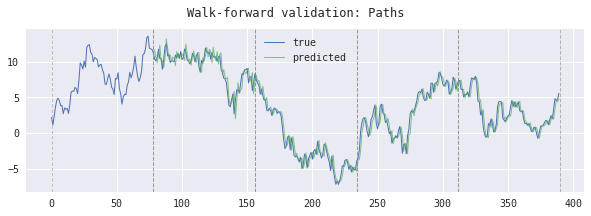

In [21]:
# -- Test run
test_mae_df, test_mse_df = experiment(
    n_iter=1,
    n_points=n_points,
    n_warmup=n_warmup,
    data_fun=data_fun,
    n_shifts=n_shifts,
    model=model,
    k_folds=k_folds,
    cv_fun=cv_fun,
    verbose=True,
)


MAE:


mean    std
0    NaN    NaN
1  0.878  0.118
2  0.825  0.090
3  0.822  0.084
4  0.815  0.077

MSE:


mean    std
1  1.209  0.345
2  1.071  0.222
3  1.058  0.197
4  1.054  0.197

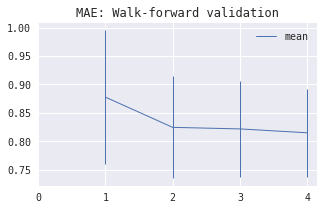

In [22]:
test_mae_df, test_mse_df = experiment(
    n_iter=n_iter,
    n_points=n_points,
    n_warmup=n_warmup,
    data_fun=data_fun,
    n_shifts=n_shifts,
    model=model,
    k_folds=k_folds,
    cv_fun=cv_fun,
    verbose=False,
)

show_results(test_mae_df, test_mse_df, cv_title)

### Moving-origin Forward Validation

In [23]:
cv_fun = partial(walk_forward, unbounded_fold=True)
cv_title = "Moving-origin Forward validation"

2023-09-29T08:45:34.214893+0200 DEBUG 62: fold=0 coef=None mae_test=nan
2023-09-29T08:45:34.217640+0200 DEBUG 62: fold=1 coef=[1.138 -0.127 -0.259 0.344 -0.252 0.331 -0.132 -0.210 0.268 -0.092] mae_test=0.851
2023-09-29T08:45:34.219948+0200 DEBUG 62: fold=2 coef=[0.990 -0.077 0.002 0.149 -0.152 0.169 -0.078 -0.078 0.059 0.014] mae_test=0.773
2023-09-29T08:45:34.221495+0200 DEBUG 62: fold=3 coef=[0.968 -0.060 0.046 0.108 -0.150 0.189 -0.100 -0.071 0.046 0.017] mae_test=0.784
2023-09-29T08:45:34.223172+0200 DEBUG 62: fold=4 coef=[1.015 -0.116 0.076 0.033 -0.082 0.138 -0.046 -0.040 -0.005 0.019] mae_test=0.680


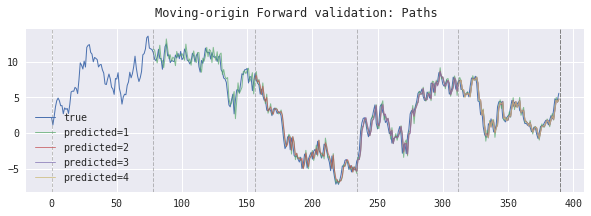

In [24]:
# -- Test run
test_mae_df, test_mse_df = experiment(
    n_iter=1,
    n_points=n_points,
    n_warmup=n_warmup,
    data_fun=data_fun,
    n_shifts=n_shifts,
    model=model,
    k_folds=k_folds,
    cv_fun=cv_fun,
    verbose=True,
)

MAE:


mean    std
0    NaN    NaN
1  0.918  0.175
2  0.850  0.102
3  0.826  0.067
4  0.815  0.077

MSE:


mean    std
1  1.350  0.631
2  1.143  0.306
3  1.075  0.171
4  1.054  0.197

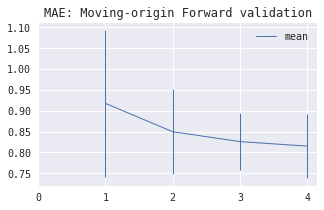

In [25]:
test_mae_df, test_mse_df = experiment(
    n_iter=n_iter,
    n_points=n_points,
    n_warmup=n_warmup,
    data_fun=data_fun,
    n_shifts=n_shifts,
    model=model,
    k_folds=k_folds,
    cv_fun=cv_fun,
    verbose=False,
)

show_results(test_mae_df, test_mse_df, cv_title)

### Blocked K-Fold CV

In [26]:
cv_fun = blocked_cv
cv_title = "Blocked K-fold CV"

2023-09-29T08:45:34.811021+0200 DEBUG 28: fold=0 coef=[1.014 -0.118 0.130 -0.058 -0.019 0.029 0.047 -0.052 -0.010 0.021] mae_test=0.829
2023-09-29T08:45:34.813215+0200 DEBUG 28: fold=1 coef=[1.075 -0.116 -0.006 0.029 -0.052 0.112 0.005 -0.087 0.015 0.013] mae_test=0.817
2023-09-29T08:45:34.815461+0200 DEBUG 28: fold=2 coef=[1.059 -0.124 0.019 0.030 -0.034 0.047 0.039 -0.063 -0.008 0.026] mae_test=0.769
2023-09-29T08:45:34.817319+0200 DEBUG 28: fold=3 coef=[1.001 -0.054 0.011 0.077 -0.114 0.127 -0.035 -0.088 0.047 0.020] mae_test=0.863
2023-09-29T08:45:34.818578+0200 DEBUG 28: fold=4 coef=[1.015 -0.116 0.076 0.033 -0.082 0.138 -0.046 -0.040 -0.005 0.019] mae_test=0.680


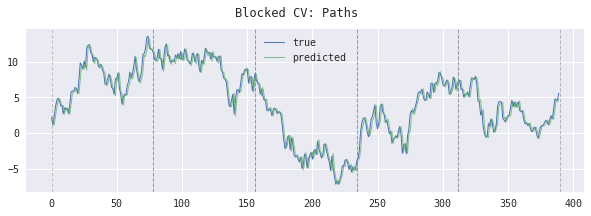

In [27]:
# -- Test run
test_mae_df, test_mse_df = experiment(
    n_iter=1,
    n_points=n_points,
    n_warmup=n_warmup,
    data_fun=data_fun,
    n_shifts=n_shifts,
    model=model,
    k_folds=k_folds,
    cv_fun=cv_fun,
    verbose=True,
)


MAE:


mean    std
0  0.824  0.070
1  0.809  0.073
2  0.801  0.074
3  0.810  0.077
4  0.815  0.077

MSE:


mean    std
0  1.062  0.168
1  1.021  0.172
2  1.012  0.176
3  1.028  0.178
4  1.054  0.197

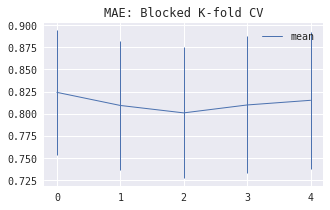

In [28]:
test_mae_df, test_mse_df = experiment(
    n_iter=n_iter,
    n_points=n_points,
    n_warmup=n_warmup,
    data_fun=data_fun,
    n_shifts=n_shifts,
    model=model,
    k_folds=k_folds,
    cv_fun=cv_fun,
    verbose=False,
)

show_results(test_mae_df, test_mse_df, cv_title)

### Combinatorial Purged CV

In [29]:
cv_fun = combinatorial_cv
cv_title = "Combinatorial CV"

2023-09-29T08:45:35.455460+0200 DEBUG 48: fold=(0, 1) coef=[1.063 -0.145 0.098 -0.086 0.011 0.030 0.079 -0.084 -0.007 0.011] mae_test=0.843
2023-09-29T08:45:35.457520+0200 DEBUG 48: fold=(0, 2) coef=[1.052 -0.159 0.132 -0.085 0.042 -0.057 0.119 -0.059 -0.024 0.025] mae_test=0.808
2023-09-29T08:45:35.459724+0200 DEBUG 48: fold=(0, 3) coef=[0.950 -0.039 0.111 0.001 -0.084 0.050 0.000 -0.063 0.027 0.030] mae_test=0.847
2023-09-29T08:45:35.462941+0200 DEBUG 48: fold=(0, 4) coef=[0.984 -0.133 0.186 -0.058 -0.034 0.069 -0.003 -0.015 -0.035 0.024] mae_test=0.762
2023-09-29T08:45:35.465364+0200 DEBUG 48: fold=(1, 2) coef=[1.122 -0.145 -0.061 0.055 -0.011 0.041 0.062 -0.089 -0.004 0.024] mae_test=0.812
2023-09-29T08:45:35.467127+0200 DEBUG 48: fold=(1, 3) coef=[1.055 -0.057 -0.078 0.104 -0.119 0.172 -0.040 -0.130 0.080 0.004] mae_test=0.842
2023-09-29T08:45:35.470055+0200 DEBUG 48: fold=(1, 4) coef=[1.063 -0.133 0.020 0.043 -0.079 0.176 -0.053 -0.060 0.007 0.008] mae_test=0.744
2023-09-29T08:45

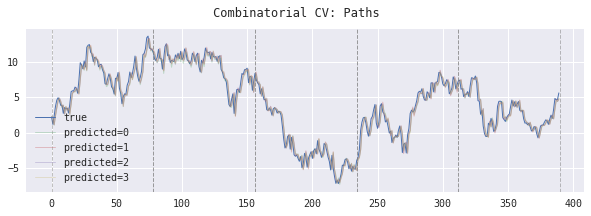

In [30]:
test_mae_df, test_mse_df = experiment(
    n_iter=1,
    n_points=n_points,
    n_warmup=n_warmup,
    data_fun=data_fun,
    n_shifts=n_shifts,
    model=model,
    k_folds=k_folds,
    cv_fun=cv_fun,
    verbose=True,
)

MAE:


mean    std
0  0.824  0.070
1  0.810  0.073
2  0.801  0.074
3  0.810  0.077
4  0.816  0.077

MSE:


mean    std
0  1.062  0.167
1  1.021  0.172
2  1.011  0.176
3  1.029  0.177
4  1.056  0.197

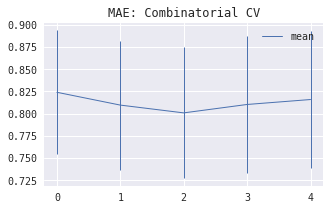

In [31]:
test_mae_df, test_mse_df = experiment(
    n_iter=n_iter,
    n_points=n_points,
    n_warmup=n_warmup,
    data_fun=data_fun,
    n_shifts=n_shifts,
    model=model,
    k_folds=k_folds,
    cv_fun=cv_fun,
    verbose=False,
)

show_results(test_mae_df, test_mse_df, "Combinatorial CV")

## Experiment 1.b: Gaussian process + Linear Regression (with intercept)

The best predictor is simply the last value.

In [32]:
# -- Additional experiment parameters
model = LinearRegression(fit_intercept=True)
data_fun = gaussian_process_data

### Walk-forward Validation

In [33]:
cv_fun = walk_forward
cv_title = "Walk-forward validation"

2023-09-29T08:45:36.594692+0200 DEBUG 62: fold=0 coef=None mae_test=nan
2023-09-29T08:45:36.597170+0200 DEBUG 62: fold=1 coef=[1.091 -0.119 -0.254 0.334 -0.254 0.317 -0.119 -0.222 0.252 -0.089] mae_test=0.869
2023-09-29T08:45:36.599222+0200 DEBUG 62: fold=2 coef=[0.943 -0.079 -0.002 0.148 -0.151 0.162 -0.074 -0.084 0.054 0.001] mae_test=1.119
2023-09-29T08:45:36.601850+0200 DEBUG 62: fold=3 coef=[0.968 -0.060 0.046 0.108 -0.150 0.189 -0.100 -0.071 0.046 0.018] mae_test=0.877
2023-09-29T08:45:36.604038+0200 DEBUG 62: fold=4 coef=[1.010 -0.116 0.075 0.033 -0.082 0.138 -0.045 -0.041 -0.005 0.016] mae_test=0.672


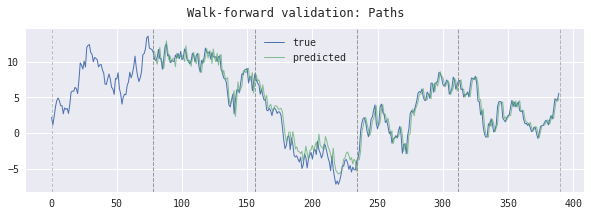

In [34]:
# -- Test run
test_mae_df, test_mse_df = experiment(
    n_iter=1,
    n_points=n_points,
    n_warmup=n_warmup,
    data_fun=data_fun,
    n_shifts=n_shifts,
    model=model,
    k_folds=k_folds,
    cv_fun=cv_fun,
    verbose=True,
)


MAE:


mean    std
0    NaN    NaN
1  0.945  0.194
2  0.849  0.109
3  0.828  0.089
4  0.823  0.081

MSE:


mean    std
1  1.411  0.616
2  1.137  0.276
3  1.074  0.213
4  1.074  0.208

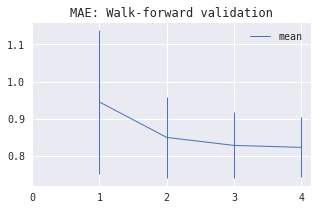

In [35]:
test_mae_df, test_mse_df = experiment(
    n_iter=n_iter,
    n_points=n_points,
    n_warmup=n_warmup,
    data_fun=data_fun,
    n_shifts=n_shifts,
    model=model,
    k_folds=k_folds,
    cv_fun=cv_fun,
    verbose=False,
)

show_results(test_mae_df, test_mse_df, cv_title)

### Moving-origin Forward Validation

In [36]:
cv_fun = partial(walk_forward, unbounded_fold=True)
cv_title = "Moving-origin Forward validation"

2023-09-29T08:45:37.178302+0200 DEBUG 62: fold=0 coef=None mae_test=nan
2023-09-29T08:45:37.180863+0200 DEBUG 62: fold=1 coef=[1.091 -0.119 -0.254 0.334 -0.254 0.317 -0.119 -0.222 0.252 -0.089] mae_test=0.897
2023-09-29T08:45:37.183132+0200 DEBUG 62: fold=2 coef=[0.943 -0.079 -0.002 0.148 -0.151 0.162 -0.074 -0.084 0.054 0.001] mae_test=0.902
2023-09-29T08:45:37.185076+0200 DEBUG 62: fold=3 coef=[0.968 -0.060 0.046 0.108 -0.150 0.189 -0.100 -0.071 0.046 0.018] mae_test=0.786
2023-09-29T08:45:37.186974+0200 DEBUG 62: fold=4 coef=[1.010 -0.116 0.075 0.033 -0.082 0.138 -0.045 -0.041 -0.005 0.016] mae_test=0.672


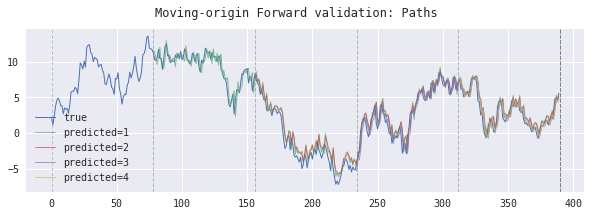

In [37]:
# -- Test run
test_mae_df, test_mse_df = experiment(
    n_iter=1,
    n_points=n_points,
    n_warmup=n_warmup,
    data_fun=data_fun,
    n_shifts=n_shifts,
    model=model,
    k_folds=k_folds,
    cv_fun=cv_fun,
    verbose=True,
)

In [38]:
test_mae_df, test_mse_df = experiment(
    n_iter=n_iter,
    n_points=n_points,
    n_warmup=n_warmup,
    data_fun=data_fun,
    n_shifts=n_shifts,
    model=model,
    k_folds=k_folds,
    cv_fun=cv_fun,
    verbose=False,
)

show_results(test_mae_df, test_mse_df, cv_title)

MAE:


mean    std
0    NaN    NaN
1  1.175  0.507
2  0.933  0.260
3  0.842  0.082
4  0.823  0.081

MSE:


mean    std
1  2.382  2.505
2  1.437  1.247
3  1.119  0.215
4  1.074  0.208

### Blocked K-Fold CV

In [39]:
cv_fun = blocked_cv
cv_title = "Blocked K-fold CV"

In [40]:
# -- Test run
test_mae_df, test_mse_df = experiment(
    n_iter=1,
    n_points=n_points,
    n_warmup=n_warmup,
    data_fun=data_fun,
    n_shifts=n_shifts,
    model=model,
    k_folds=k_folds,
    cv_fun=cv_fun,
    verbose=True,
)


2023-09-29T08:45:37.895217+0200 DEBUG 28: fold=0 coef=[1.011 -0.118 0.130 -0.058 -0.019 0.028 0.047 -0.052 -0.010 0.017] mae_test=0.825
2023-09-29T08:45:37.897208+0200 DEBUG 28: fold=1 coef=[1.070 -0.116 -0.006 0.029 -0.052 0.112 0.006 -0.087 0.015 0.009] mae_test=0.814
2023-09-29T08:45:37.899394+0200 DEBUG 28: fold=2 coef=[1.029 -0.121 0.017 0.031 -0.035 0.046 0.040 -0.063 -0.010 0.021] mae_test=0.852
2023-09-29T08:45:37.900602+0200 DEBUG 28: fold=3 coef=[1.000 -0.054 0.012 0.077 -0.114 0.127 -0.035 -0.088 0.047 0.018] mae_test=0.859
2023-09-29T08:45:37.902452+0200 DEBUG 28: fold=4 coef=[1.010 -0.116 0.075 0.033 -0.082 0.138 -0.045 -0.041 -0.005 0.016] mae_test=0.672


In [41]:
test_mae_df, test_mse_df = experiment(
    n_iter=n_iter,
    n_points=n_points,
    n_warmup=n_warmup,
    data_fun=data_fun,
    n_shifts=n_shifts,
    model=model,
    k_folds=k_folds,
    cv_fun=cv_fun,
    verbose=False,
)

show_results(test_mae_df, test_mse_df, cv_title)

MAE:


mean    std
0  0.837  0.078
1  0.812  0.074
2  0.801  0.075
3  0.808  0.078
4  0.823  0.081

MSE:


mean    std
0  1.099  0.193
1  1.026  0.178
2  1.011  0.178
3  1.024  0.178
4  1.074  0.208

### Combinatorial Purged CV

In [42]:
cv_fun = combinatorial_cv
cv_title = "Combinatorial CV"

2023-09-29T08:45:38.602893+0200 DEBUG 48: fold=(0, 1) coef=[1.060 -0.145 0.098 -0.086 0.011 0.030 0.079 -0.084 -0.007 0.008] mae_test=0.840
2023-09-29T08:45:38.604460+0200 DEBUG 48: fold=(0, 2) coef=[1.022 -0.156 0.127 -0.081 0.040 -0.055 0.118 -0.057 -0.025 0.019] mae_test=0.841
2023-09-29T08:45:38.606267+0200 DEBUG 48: fold=(0, 3) coef=[0.948 -0.039 0.111 0.001 -0.084 0.051 0.000 -0.062 0.027 0.036] mae_test=0.856
2023-09-29T08:45:38.607614+0200 DEBUG 48: fold=(0, 4) coef=[0.983 -0.133 0.186 -0.057 -0.034 0.069 -0.003 -0.015 -0.035 0.021] mae_test=0.757
2023-09-29T08:45:38.609450+0200 DEBUG 48: fold=(1, 2) coef=[1.089 -0.140 -0.062 0.055 -0.014 0.040 0.064 -0.090 -0.008 0.019] mae_test=0.844
2023-09-29T08:45:38.611878+0200 DEBUG 48: fold=(1, 3) coef=[1.055 -0.057 -0.078 0.104 -0.119 0.172 -0.040 -0.130 0.080 0.004] mae_test=0.841
2023-09-29T08:45:38.613591+0200 DEBUG 48: fold=(1, 4) coef=[1.058 -0.132 0.020 0.044 -0.079 0.175 -0.052 -0.061 0.007 0.006] mae_test=0.741
2023-09-29T08:45

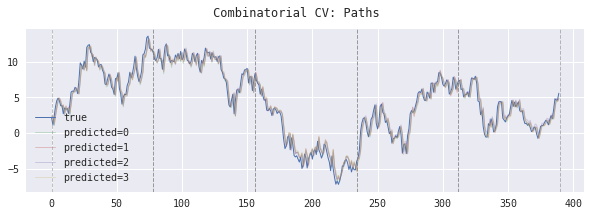

In [43]:
test_mae_df, test_mse_df = experiment(
    n_iter=1,
    n_points=n_points,
    n_warmup=n_warmup,
    data_fun=data_fun,
    n_shifts=n_shifts,
    model=model,
    k_folds=k_folds,
    cv_fun=cv_fun,
    verbose=True,
)

MAE:


mean    std
0  0.842  0.081
1  0.811  0.075
2  0.801  0.075
3  0.809  0.078
4  0.827  0.082

MSE:


mean    std
0  1.113  0.203
1  1.026  0.179
2  1.011  0.177
3  1.026  0.179
4  1.086  0.215

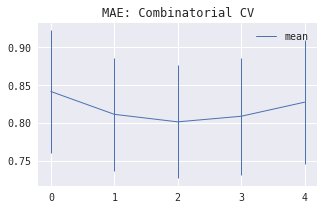

In [44]:
test_mae_df, test_mse_df = experiment(
    n_iter=n_iter,
    n_points=n_points,
    n_warmup=n_warmup,
    data_fun=data_fun,
    n_shifts=n_shifts,
    model=model,
    k_folds=k_folds,
    cv_fun=cv_fun,
    verbose=False,
)

show_results(test_mae_df, test_mse_df, "Combinatorial CV")

## Experiment 2.a: ARMA process + Linear Regression

In [45]:
# -- Additional experiment parameters
model = LinearRegression(fit_intercept=False)
data_fun = partial(arma_process_data, ar_params=(0.3, 0.2, -0.1), ma_params=(0.6, -0.3, 0.5, 0.2), stdev=0.5)

### Walk-forward Validation

In [46]:
cv_fun = walk_forward
cv_title = "Walk-forward validation"

2023-09-29T08:45:39.809484+0200 DEBUG 62: fold=0 coef=None mae_test=nan
2023-09-29T08:45:39.812733+0200 DEBUG 62: fold=1 coef=[0.783 -0.276 0.270 -0.134 -0.045 0.083 0.012 -0.121 0.182 0.009] mae_test=0.499
2023-09-29T08:45:39.815808+0200 DEBUG 62: fold=2 coef=[0.644 -0.277 0.470 -0.216 0.059 -0.110 0.041 -0.083 0.049 0.040] mae_test=0.426
2023-09-29T08:45:39.818913+0200 DEBUG 62: fold=3 coef=[0.629 -0.275 0.521 -0.248 0.076 -0.107 0.032 -0.069 0.026 0.074] mae_test=0.512
2023-09-29T08:45:39.820631+0200 DEBUG 62: fold=4 coef=[0.668 -0.303 0.540 -0.320 0.131 -0.166 0.107 -0.070 0.025 0.058] mae_test=0.381


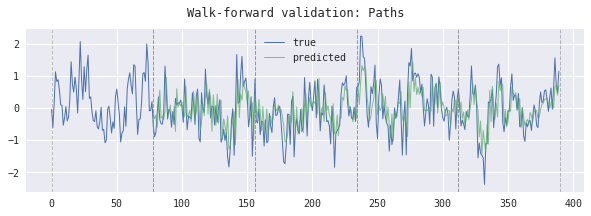

In [47]:
# -- Test run
test_mae_df, test_mse_df = experiment(
    n_iter=1,
    n_points=n_points,
    n_warmup=n_warmup,
    data_fun=data_fun,
    n_shifts=n_shifts,
    model=model,
    k_folds=k_folds,
    cv_fun=cv_fun,
    verbose=True,
)


MAE:


mean    std
0    NaN    NaN
1  0.484  0.055
2  0.465  0.042
3  0.461  0.040
4  0.450  0.040

MSE:


mean    std
1  0.370  0.083
2  0.342  0.056
3  0.334  0.059
4  0.324  0.056

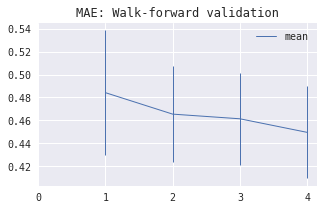

In [48]:
test_mae_df, test_mse_df = experiment(
    n_iter=n_iter,
    n_points=n_points,
    n_warmup=n_warmup,
    data_fun=data_fun,
    n_shifts=n_shifts,
    model=model,
    k_folds=k_folds,
    cv_fun=cv_fun,
    verbose=False,
)

show_results(test_mae_df, test_mse_df, cv_title)

### Moving-origin Forward Validation

In [49]:
cv_fun = partial(walk_forward, unbounded_fold=True)
cv_title = "Moving-origin Forward validation"

2023-09-29T08:45:40.630692+0200 DEBUG 62: fold=0 coef=None mae_test=nan
2023-09-29T08:45:40.632248+0200 DEBUG 62: fold=1 coef=[0.783 -0.276 0.270 -0.134 -0.045 0.083 0.012 -0.121 0.182 0.009] mae_test=0.486
2023-09-29T08:45:40.634195+0200 DEBUG 62: fold=2 coef=[0.644 -0.277 0.470 -0.216 0.059 -0.110 0.041 -0.083 0.049 0.040] mae_test=0.442
2023-09-29T08:45:40.635710+0200 DEBUG 62: fold=3 coef=[0.629 -0.275 0.521 -0.248 0.076 -0.107 0.032 -0.069 0.026 0.074] mae_test=0.450
2023-09-29T08:45:40.637337+0200 DEBUG 62: fold=4 coef=[0.668 -0.303 0.540 -0.320 0.131 -0.166 0.107 -0.070 0.025 0.058] mae_test=0.381


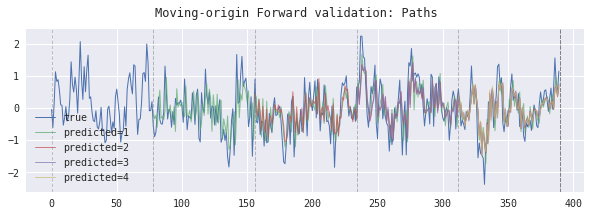

In [50]:
# -- Test run
test_mae_df, test_mse_df = experiment(
    n_iter=1,
    n_points=n_points,
    n_warmup=n_warmup,
    data_fun=data_fun,
    n_shifts=n_shifts,
    model=model,
    k_folds=k_folds,
    cv_fun=cv_fun,
    verbose=True,
)

MAE:


mean    std
0    NaN    NaN
1  0.479  0.029
2  0.462  0.025
3  0.457  0.029
4  0.450  0.040

MSE:


mean    std
1  0.363  0.043
2  0.338  0.036
3  0.331  0.043
4  0.324  0.056

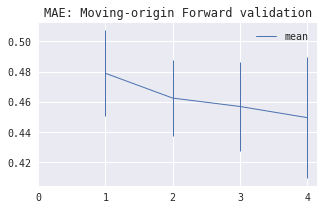

In [51]:
test_mae_df, test_mse_df = experiment(
    n_iter=n_iter,
    n_points=n_points,
    n_warmup=n_warmup,
    data_fun=data_fun,
    n_shifts=n_shifts,
    model=model,
    k_folds=k_folds,
    cv_fun=cv_fun,
    verbose=False,
)

show_results(test_mae_df, test_mse_df, cv_title)

### Blocked K-Fold CV

In [52]:
cv_fun = blocked_cv
cv_title = "Blocked K-fold CV"

2023-09-29T08:45:41.460865+0200 DEBUG 28: fold=0 coef=[0.668 -0.290 0.582 -0.368 0.174 -0.272 0.186 -0.120 0.058 0.010] mae_test=0.456
2023-09-29T08:45:41.463657+0200 DEBUG 28: fold=1 coef=[0.724 -0.275 0.482 -0.338 0.128 -0.172 0.164 -0.105 0.054 0.031] mae_test=0.472
2023-09-29T08:45:41.466030+0200 DEBUG 28: fold=2 coef=[0.705 -0.281 0.489 -0.322 0.143 -0.230 0.177 -0.112 0.061 0.005] mae_test=0.424
2023-09-29T08:45:41.468181+0200 DEBUG 28: fold=3 coef=[0.659 -0.251 0.498 -0.273 0.088 -0.162 0.100 -0.112 0.063 0.030] mae_test=0.510
2023-09-29T08:45:41.469867+0200 DEBUG 28: fold=4 coef=[0.668 -0.303 0.540 -0.320 0.131 -0.166 0.107 -0.070 0.025 0.058] mae_test=0.381


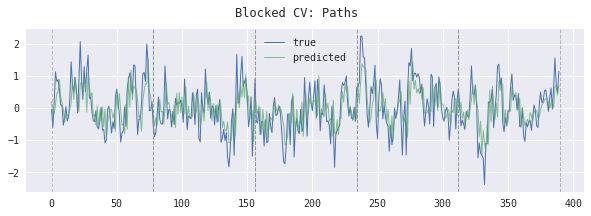

In [53]:
# -- Test run
test_mae_df, test_mse_df = experiment(
    n_iter=1,
    n_points=n_points,
    n_warmup=n_warmup,
    data_fun=data_fun,
    n_shifts=n_shifts,
    model=model,
    k_folds=k_folds,
    cv_fun=cv_fun,
    verbose=True,
)


In [54]:
test_mae_df, test_mse_df = experiment(
    n_iter=n_iter,
    n_points=n_points,
    n_warmup=n_warmup,
    data_fun=data_fun,
    n_shifts=n_shifts,
    model=model,
    k_folds=k_folds,
    cv_fun=cv_fun,
    verbose=False,
)

show_results(test_mae_df, test_mse_df, cv_title)

MAE:


mean    std
0  0.460  0.041
1  0.462  0.046
2  0.460  0.040
3  0.459  0.039
4  0.450  0.040

MSE:


mean    std
0  0.330  0.055
1  0.337  0.067
2  0.333  0.053
3  0.330  0.057
4  0.324  0.056

### Combinatorial Purged CV

In [55]:
cv_fun = combinatorial_cv
cv_title = "Combinatorial CV"

In [56]:
test_mae_df, test_mse_df = experiment(
    n_iter=1,
    n_points=n_points,
    n_warmup=n_warmup,
    data_fun=data_fun,
    n_shifts=n_shifts,
    model=model,
    k_folds=k_folds,
    cv_fun=cv_fun,
    verbose=True,
)

2023-09-29T08:45:42.329443+0200 DEBUG 48: fold=(0, 1) coef=[0.717 -0.287 0.556 -0.404 0.179 -0.258 0.225 -0.123 0.060 0.008] mae_test=0.461
2023-09-29T08:45:42.331567+0200 DEBUG 48: fold=(0, 2) coef=[0.691 -0.299 0.567 -0.388 0.207 -0.334 0.242 -0.140 0.075 -0.026] mae_test=0.440
2023-09-29T08:45:42.333812+0200 DEBUG 48: fold=(0, 3) coef=[0.615 -0.248 0.574 -0.299 0.125 -0.246 0.124 -0.130 0.064 0.018] mae_test=0.486
2023-09-29T08:45:42.335841+0200 DEBUG 48: fold=(0, 4) coef=[0.644 -0.324 0.624 -0.369 0.190 -0.252 0.147 -0.090 0.028 0.046] mae_test=0.422
2023-09-29T08:45:42.337860+0200 DEBUG 48: fold=(1, 2) coef=[0.762 -0.275 0.427 -0.325 0.145 -0.211 0.207 -0.115 0.064 0.007] mae_test=0.459
2023-09-29T08:45:42.339881+0200 DEBUG 48: fold=(1, 3) coef=[0.711 -0.238 0.440 -0.282 0.070 -0.110 0.113 -0.123 0.080 0.032] mae_test=0.491
2023-09-29T08:45:42.341843+0200 DEBUG 48: fold=(1, 4) coef=[0.709 -0.302 0.500 -0.336 0.124 -0.122 0.116 -0.061 0.022 0.072] mae_test=0.426
2023-09-29T08:45:42

In [57]:
test_mae_df, test_mse_df = experiment(
    n_iter=n_iter,
    n_points=n_points,
    n_warmup=n_warmup,
    data_fun=data_fun,
    n_shifts=n_shifts,
    model=model,
    k_folds=k_folds,
    cv_fun=cv_fun,
    verbose=False,
)

show_results(test_mae_df, test_mse_df, "Combinatorial CV")

MAE:


mean    std
0  0.460  0.041
1  0.462  0.047
2  0.460  0.040
3  0.459  0.039
4  0.450  0.040

MSE:


mean    std
0  0.330  0.055
1  0.337  0.067
2  0.333  0.053
3  0.330  0.057
4  0.324  0.057

## Experiment 2.b: ARMA process + Linear Regression (with intercept)

In [58]:
# -- Additional experiment parameters
model = LinearRegression(fit_intercept=True)
data_fun = partial(arma_process_data, ar_params=(0.3, 0.2, -0.1), ma_params=(0.6, -0.3, 0.5, 0.2), stdev=0.5)

### Walk-forward Validation

In [59]:
cv_fun = walk_forward
cv_title = "Walk-forward validation"

2023-09-29T08:45:43.679924+0200 DEBUG 62: fold=0 coef=None mae_test=nan
2023-09-29T08:45:43.683042+0200 DEBUG 62: fold=1 coef=[0.769 -0.280 0.261 -0.137 -0.051 0.077 0.008 -0.126 0.177 -0.000] mae_test=0.503
2023-09-29T08:45:43.684897+0200 DEBUG 62: fold=2 coef=[0.643 -0.278 0.469 -0.216 0.058 -0.111 0.040 -0.083 0.048 0.039] mae_test=0.431
2023-09-29T08:45:43.686622+0200 DEBUG 62: fold=3 coef=[0.628 -0.276 0.520 -0.248 0.076 -0.108 0.032 -0.070 0.026 0.073] mae_test=0.517
2023-09-29T08:45:43.688354+0200 DEBUG 62: fold=4 coef=[0.668 -0.303 0.540 -0.320 0.131 -0.166 0.107 -0.070 0.024 0.058] mae_test=0.381


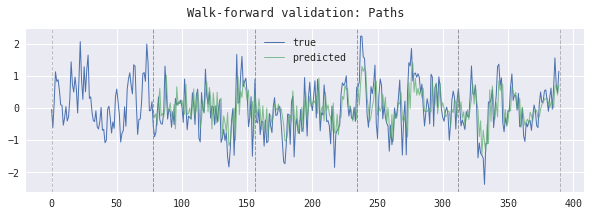

In [60]:
# -- Test run
test_mae_df, test_mse_df = experiment(
    n_iter=1,
    n_points=n_points,
    n_warmup=n_warmup,
    data_fun=data_fun,
    n_shifts=n_shifts,
    model=model,
    k_folds=k_folds,
    cv_fun=cv_fun,
    verbose=True,
)


MAE:


mean    std
0    NaN    NaN
1  0.494  0.059
2  0.468  0.041
3  0.463  0.041
4  0.451  0.040

MSE:


mean    std
1  0.385  0.092
2  0.345  0.055
3  0.336  0.060
4  0.326  0.056

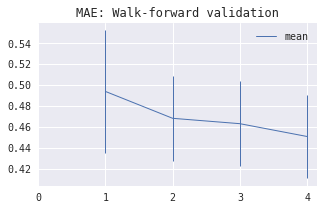

In [61]:
test_mae_df, test_mse_df = experiment(
    n_iter=n_iter,
    n_points=n_points,
    n_warmup=n_warmup,
    data_fun=data_fun,
    n_shifts=n_shifts,
    model=model,
    k_folds=k_folds,
    cv_fun=cv_fun,
    verbose=False,
)

show_results(test_mae_df, test_mse_df, cv_title)

### Moving-origin Forward Validation

In [62]:
cv_fun = partial(walk_forward, unbounded_fold=True)
cv_title = "Moving-origin Forward validation"

2023-09-29T08:45:44.495114+0200 DEBUG 62: fold=0 coef=None mae_test=nan
2023-09-29T08:45:44.497790+0200 DEBUG 62: fold=1 coef=[0.769 -0.280 0.261 -0.137 -0.051 0.077 0.008 -0.126 0.177 -0.000] mae_test=0.487
2023-09-29T08:45:44.499761+0200 DEBUG 62: fold=2 coef=[0.643 -0.278 0.469 -0.216 0.058 -0.111 0.040 -0.083 0.048 0.039] mae_test=0.442
2023-09-29T08:45:44.501359+0200 DEBUG 62: fold=3 coef=[0.628 -0.276 0.520 -0.248 0.076 -0.108 0.032 -0.070 0.026 0.073] mae_test=0.453
2023-09-29T08:45:44.504123+0200 DEBUG 62: fold=4 coef=[0.668 -0.303 0.540 -0.320 0.131 -0.166 0.107 -0.070 0.024 0.058] mae_test=0.381


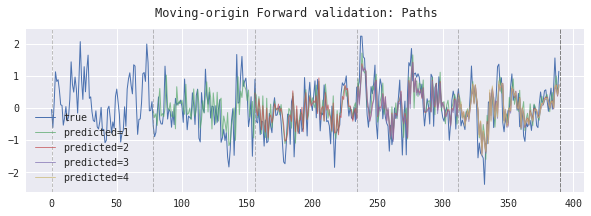

In [63]:
# -- Test run
test_mae_df, test_mse_df = experiment(
    n_iter=1,
    n_points=n_points,
    n_warmup=n_warmup,
    data_fun=data_fun,
    n_shifts=n_shifts,
    model=model,
    k_folds=k_folds,
    cv_fun=cv_fun,
    verbose=True,
)

MAE:


mean    std
0    NaN    NaN
1  0.488  0.037
2  0.465  0.025
3  0.459  0.030
4  0.451  0.040

MSE:


mean    std
1  0.377  0.059
2  0.341  0.036
3  0.333  0.044
4  0.326  0.056

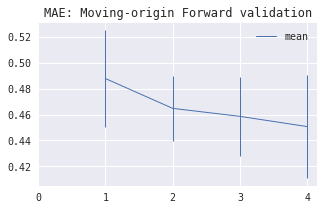

In [64]:
test_mae_df, test_mse_df = experiment(
    n_iter=n_iter,
    n_points=n_points,
    n_warmup=n_warmup,
    data_fun=data_fun,
    n_shifts=n_shifts,
    model=model,
    k_folds=k_folds,
    cv_fun=cv_fun,
    verbose=False,
)

show_results(test_mae_df, test_mse_df, cv_title)

### Blocked K-Fold CV

In [65]:
cv_fun = blocked_cv
cv_title = "Blocked K-fold CV"

2023-09-29T08:45:45.330931+0200 DEBUG 28: fold=0 coef=[0.668 -0.290 0.581 -0.368 0.174 -0.272 0.186 -0.120 0.058 0.009] mae_test=0.456
2023-09-29T08:45:45.333727+0200 DEBUG 28: fold=1 coef=[0.723 -0.275 0.481 -0.338 0.128 -0.172 0.164 -0.105 0.054 0.030] mae_test=0.474
2023-09-29T08:45:45.337020+0200 DEBUG 28: fold=2 coef=[0.702 -0.282 0.487 -0.322 0.142 -0.231 0.177 -0.113 0.060 0.003] mae_test=0.432
2023-09-29T08:45:45.339533+0200 DEBUG 28: fold=3 coef=[0.658 -0.252 0.497 -0.274 0.088 -0.163 0.100 -0.113 0.062 0.028] mae_test=0.516
2023-09-29T08:45:45.342129+0200 DEBUG 28: fold=4 coef=[0.668 -0.303 0.540 -0.320 0.131 -0.166 0.107 -0.070 0.024 0.058] mae_test=0.381


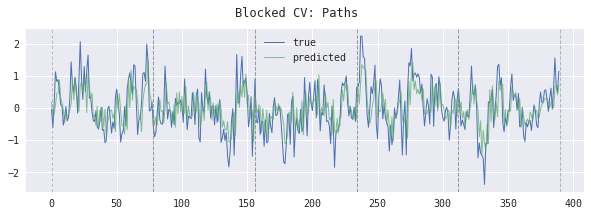

In [66]:
# -- Test run
test_mae_df, test_mse_df = experiment(
    n_iter=1,
    n_points=n_points,
    n_warmup=n_warmup,
    data_fun=data_fun,
    n_shifts=n_shifts,
    model=model,
    k_folds=k_folds,
    cv_fun=cv_fun,
    verbose=True,
)


MAE:


mean    std
0  0.461  0.042
1  0.463  0.047
2  0.461  0.040
3  0.460  0.039
4  0.451  0.040

MSE:


mean    std
0  0.332  0.055
1  0.338  0.067
2  0.335  0.053
3  0.331  0.058
4  0.326  0.056

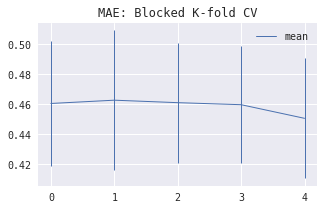

In [67]:
test_mae_df, test_mse_df = experiment(
    n_iter=n_iter,
    n_points=n_points,
    n_warmup=n_warmup,
    data_fun=data_fun,
    n_shifts=n_shifts,
    model=model,
    k_folds=k_folds,
    cv_fun=cv_fun,
    verbose=False,
)

show_results(test_mae_df, test_mse_df, cv_title)

### Combinatorial Purged CV

In [68]:
cv_fun = combinatorial_cv
cv_title = "Combinatorial CV"

In [69]:
test_mae_df, test_mse_df = experiment(
    n_iter=1,
    n_points=n_points,
    n_warmup=n_warmup,
    data_fun=data_fun,
    n_shifts=n_shifts,
    model=model,
    k_folds=k_folds,
    cv_fun=cv_fun,
    verbose=True,
)

2023-09-29T08:45:46.234114+0200 DEBUG 48: fold=(0, 1) coef=[0.717 -0.287 0.556 -0.404 0.179 -0.259 0.225 -0.123 0.060 0.007] mae_test=0.460
2023-09-29T08:45:46.236523+0200 DEBUG 48: fold=(0, 2) coef=[0.690 -0.299 0.566 -0.388 0.207 -0.335 0.242 -0.141 0.074 -0.026] mae_test=0.443
2023-09-29T08:45:46.238904+0200 DEBUG 48: fold=(0, 3) coef=[0.603 -0.255 0.566 -0.303 0.124 -0.248 0.123 -0.138 0.059 0.004] mae_test=0.497
2023-09-29T08:45:46.241486+0200 DEBUG 48: fold=(0, 4) coef=[0.643 -0.324 0.624 -0.369 0.190 -0.252 0.147 -0.090 0.028 0.046] mae_test=0.422
2023-09-29T08:45:46.243612+0200 DEBUG 48: fold=(1, 2) coef=[0.755 -0.277 0.422 -0.326 0.143 -0.213 0.205 -0.118 0.062 0.001] mae_test=0.469
2023-09-29T08:45:46.245962+0200 DEBUG 48: fold=(1, 3) coef=[0.711 -0.238 0.440 -0.283 0.069 -0.111 0.113 -0.124 0.080 0.031] mae_test=0.492
2023-09-29T08:45:46.248621+0200 DEBUG 48: fold=(1, 4) coef=[0.708 -0.302 0.499 -0.336 0.124 -0.122 0.116 -0.062 0.022 0.070] mae_test=0.428
2023-09-29T08:45:46

MAE:


mean    std
0  0.461  0.042
1  0.463  0.047
2  0.461  0.040
3  0.460  0.039
4  0.451  0.040

MSE:


mean    std
0  0.332  0.055
1  0.338  0.068
2  0.335  0.053
3  0.331  0.058
4  0.326  0.056

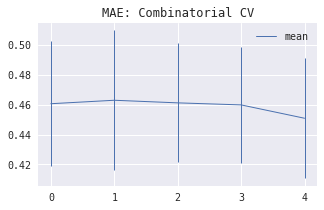

In [70]:
test_mae_df, test_mse_df = experiment(
    n_iter=n_iter,
    n_points=n_points,
    n_warmup=n_warmup,
    data_fun=data_fun,
    n_shifts=n_shifts,
    model=model,
    k_folds=k_folds,
    cv_fun=cv_fun,
    verbose=False,
)

show_results(test_mae_df, test_mse_df, "Combinatorial CV")

## Experiment 2.c: ARMA process + Gradient Boosting

In [71]:
# -- Additional experiment parameters
base_model = LGBMRegressor(
    learning_rate=0.02,
    n_estimators=200,
    num_leaves=4,
    min_child_samples=5,
    reg_alpha=0.1,
    force_col_wise=True,
    verbose=-1,
)
model = LGBMRegressorEarlyStop(
    regressor=base_model,
    eval_ratio=0.2,
    eval_metric="l2",
    stopping_rounds=5,
)

data_fun = partial(
    arma_process_data,
    ar_params=(0.3, 0.2, -0.1),
    ma_params=(0.6, -0.3, 0.5, 0.2),
    stdev=0.5,
    trend_magnitude=350.,
    trend_rate=6,
    verbose=False,
)
data_fun = partial(arma_process_data, ar_params=(0.3, 0.2, -0.1), ma_params=(0.6, -0.3, 0.5, 0.2), stdev=0.5)

### Walk-forward Validation

In [72]:
cv_fun = walk_forward
cv_title = "Walk-forward validation"

2023-09-29T08:45:47.789065+0200 DEBUG 62: fold=0 coef=None mae_test=nan
2023-09-29T08:45:47.827507+0200 DEBUG 62: fold=1 coef=None mae_test=0.539
2023-09-29T08:45:47.842366+0200 DEBUG 62: fold=2 coef=None mae_test=0.525
2023-09-29T08:45:47.856662+0200 DEBUG 62: fold=3 coef=None mae_test=0.564
2023-09-29T08:45:47.868887+0200 DEBUG 62: fold=4 coef=None mae_test=0.452


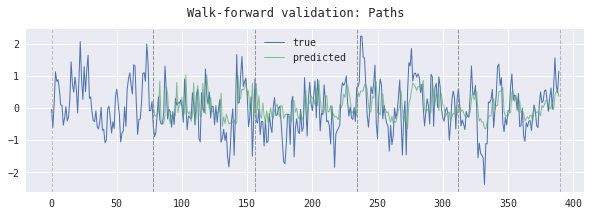

In [73]:
# -- Test run
test_mae_df, test_mse_df = experiment(
    n_iter=1,
    n_points=n_points,
    n_warmup=n_warmup,
    data_fun=data_fun,
    n_shifts=n_shifts,
    model=model,
    k_folds=k_folds,
    cv_fun=cv_fun,
    verbose=True,
)


In [74]:
test_mae_df, test_mse_df = experiment(
    n_iter=n_iter,
    n_points=n_points,
    n_warmup=n_warmup,
    data_fun=data_fun,
    n_shifts=n_shifts,
    model=model,
    k_folds=k_folds,
    cv_fun=cv_fun,
    verbose=False,
)

show_results(test_mae_df, test_mse_df, cv_title)

MAE:


mean    std
0    NaN    NaN
1  0.580  0.083
2  0.531  0.061
3  0.515  0.061
4  0.499  0.054

MSE:


mean    std
1  0.534  0.152
2  0.440  0.094
3  0.419  0.096
4  0.397  0.085

### Moving-origin Forward Validation

In [75]:
cv_fun = partial(walk_forward, unbounded_fold=True)
cv_title = "Moving-origin Forward validation"

2023-09-29T08:45:53.085043+0200 DEBUG 62: fold=0 coef=None mae_test=nan
2023-09-29T08:45:53.101479+0200 DEBUG 62: fold=1 coef=None mae_test=0.522
2023-09-29T08:45:53.116628+0200 DEBUG 62: fold=2 coef=None mae_test=0.514
2023-09-29T08:45:53.129667+0200 DEBUG 62: fold=3 coef=None mae_test=0.506
2023-09-29T08:45:53.140880+0200 DEBUG 62: fold=4 coef=None mae_test=0.452


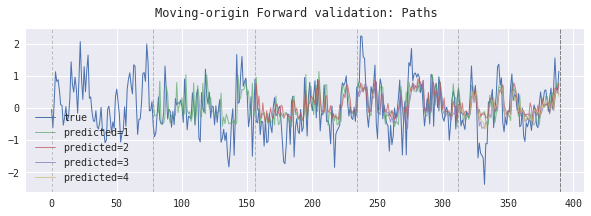

In [76]:
# -- Test run
test_mae_df, test_mse_df = experiment(
    n_iter=1,
    n_points=n_points,
    n_warmup=n_warmup,
    data_fun=data_fun,
    n_shifts=n_shifts,
    model=model,
    k_folds=k_folds,
    cv_fun=cv_fun,
    verbose=True,
)

MAE:


mean    std
0    NaN    NaN
1  0.571  0.053
2  0.529  0.043
3  0.512  0.044
4  0.499  0.054

MSE:


mean    std
1  0.517  0.095
2  0.442  0.071
3  0.415  0.073
4  0.397  0.085

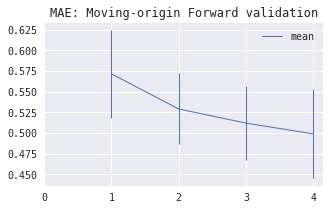

In [77]:
test_mae_df, test_mse_df = experiment(
    n_iter=n_iter,
    n_points=n_points,
    n_warmup=n_warmup,
    data_fun=data_fun,
    n_shifts=n_shifts,
    model=model,
    k_folds=k_folds,
    cv_fun=cv_fun,
    verbose=False,
)

show_results(test_mae_df, test_mse_df, cv_title)

### Blocked K-Fold CV

In [78]:
cv_fun = blocked_cv
cv_title = "Blocked K-fold CV"

2023-09-29T08:45:58.381736+0200 DEBUG 28: fold=0 coef=None mae_test=0.485
2023-09-29T08:45:58.398687+0200 DEBUG 28: fold=1 coef=None mae_test=0.522
2023-09-29T08:45:58.414516+0200 DEBUG 28: fold=2 coef=None mae_test=0.489
2023-09-29T08:45:58.438409+0200 DEBUG 28: fold=3 coef=None mae_test=0.544
2023-09-29T08:45:58.450268+0200 DEBUG 28: fold=4 coef=None mae_test=0.452


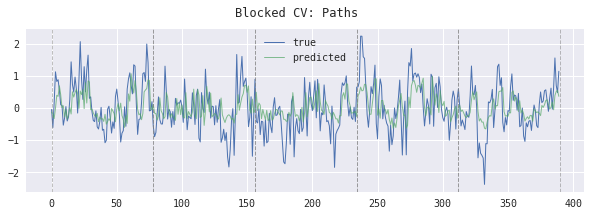

In [79]:
# -- Test run
test_mae_df, test_mse_df = experiment(
    n_iter=1,
    n_points=n_points,
    n_warmup=n_warmup,
    data_fun=data_fun,
    n_shifts=n_shifts,
    model=model,
    k_folds=k_folds,
    cv_fun=cv_fun,
    verbose=True,
)


MAE:


mean    std
0  0.506  0.052
1  0.513  0.065
2  0.511  0.051
3  0.507  0.058
4  0.499  0.054

MSE:


mean    std
0  0.402  0.081
1  0.415  0.107
2  0.407  0.077
3  0.407  0.094
4  0.397  0.085

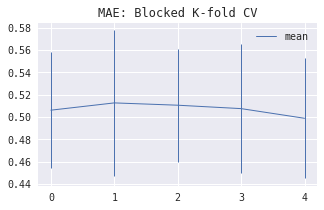

In [80]:
test_mae_df, test_mse_df = experiment(
    n_iter=n_iter,
    n_points=n_points,
    n_warmup=n_warmup,
    data_fun=data_fun,
    n_shifts=n_shifts,
    model=model,
    k_folds=k_folds,
    cv_fun=cv_fun,
    verbose=False,
)

show_results(test_mae_df, test_mse_df, cv_title)

### Combinatorial Purged CV

In [81]:
cv_fun = combinatorial_cv
cv_title = "Combinatorial CV"

2023-09-29T08:46:06.154685+0200 DEBUG 48: fold=(0, 1) coef=None mae_test=0.484
2023-09-29T08:46:06.166219+0200 DEBUG 48: fold=(0, 2) coef=None mae_test=0.480
2023-09-29T08:46:06.188410+0200 DEBUG 48: fold=(0, 3) coef=None mae_test=0.568
2023-09-29T08:46:06.201837+0200 DEBUG 48: fold=(0, 4) coef=None mae_test=0.477
2023-09-29T08:46:06.214484+0200 DEBUG 48: fold=(1, 2) coef=None mae_test=0.515
2023-09-29T08:46:06.226223+0200 DEBUG 48: fold=(1, 3) coef=None mae_test=0.542
2023-09-29T08:46:06.235831+0200 DEBUG 48: fold=(1, 4) coef=None mae_test=0.485
2023-09-29T08:46:06.246832+0200 DEBUG 48: fold=(2, 3) coef=None mae_test=0.531
2023-09-29T08:46:06.258897+0200 DEBUG 48: fold=(2, 4) coef=None mae_test=0.479
2023-09-29T08:46:06.273881+0200 DEBUG 48: fold=(3, 4) coef=None mae_test=0.506


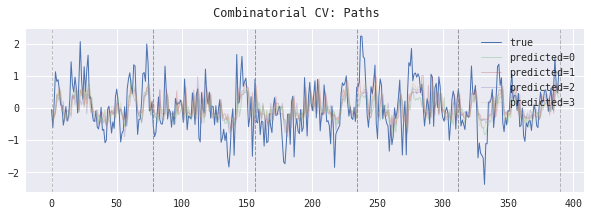

In [82]:
test_mae_df, test_mse_df = experiment(
    n_iter=1,
    n_points=n_points,
    n_warmup=n_warmup,
    data_fun=data_fun,
    n_shifts=n_shifts,
    model=model,
    k_folds=k_folds,
    cv_fun=cv_fun,
    verbose=True,
)

MAE:


mean    std
0  0.506  0.053
1  0.515  0.065
2  0.508  0.052
3  0.508  0.062
4  0.499  0.056

MSE:


mean    std
0  0.403  0.083
1  0.418  0.110
2  0.405  0.078
3  0.408  0.101
4  0.397  0.088

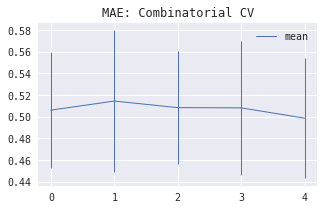

In [83]:
test_mae_df, test_mse_df = experiment(
    n_iter=n_iter,
    n_points=n_points,
    n_warmup=n_warmup,
    data_fun=data_fun,
    n_shifts=n_shifts,
    model=model,
    k_folds=k_folds,
    cv_fun=cv_fun,
    verbose=False,
)

show_results(test_mae_df, test_mse_df, "Combinatorial CV")

## Experiment 3.a: ARMA with Trend + Linear Regression

In [84]:
# -- Additional experiment parameters
model = LinearRegression(fit_intercept=False)
data_fun = partial(
    arma_process_data,
    ar_params=(0.3, 0.2, -0.1),
    ma_params=(0.6, -0.3, 0.5, 0.2),
    stdev=0.5,
    trend_magnitude=350.,
    trend_rate=6,
    verbose=False,
)

### Walk-forward Validation

In [85]:
cv_fun = walk_forward
cv_title = "Walk-forward validation"

2023-09-29T08:46:20.005251+0200 DEBUG 62: fold=0 coef=None mae_test=nan
2023-09-29T08:46:20.006950+0200 DEBUG 62: fold=1 coef=[0.679 -0.203 0.250 -0.111 -0.012 0.087 0.031 -0.017 0.193 0.160] mae_test=0.523
2023-09-29T08:46:20.009633+0200 DEBUG 62: fold=2 coef=[0.666 -0.224 0.496 -0.175 0.064 -0.086 0.039 -0.012 0.076 0.138] mae_test=0.439
2023-09-29T08:46:20.011610+0200 DEBUG 62: fold=3 coef=[0.656 -0.238 0.543 -0.219 0.084 -0.091 0.041 -0.022 0.062 0.147] mae_test=0.518
2023-09-29T08:46:20.013391+0200 DEBUG 62: fold=4 coef=[0.699 -0.271 0.560 -0.293 0.139 -0.145 0.114 -0.029 0.051 0.122] mae_test=0.422


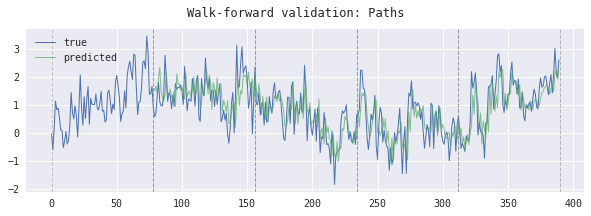

In [86]:
# -- Test run
test_mae_df, test_mse_df = experiment(
    n_iter=1,
    n_points=n_points,
    n_warmup=n_warmup,
    data_fun=data_fun,
    n_shifts=n_shifts,
    model=model,
    k_folds=k_folds,
    cv_fun=cv_fun,
    verbose=True,
)


MAE:


mean    std
0    NaN    NaN
1  0.551  0.135
2  0.507  0.065
3  0.500  0.047
4  0.490  0.052

MSE:


mean    std
1  0.488  0.272
2  0.407  0.103
3  0.397  0.070
4  0.381  0.078

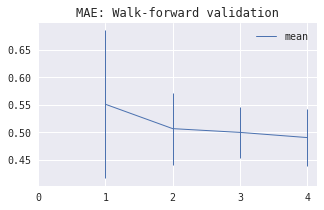

In [87]:
test_mae_df, test_mse_df = experiment(
    n_iter=n_iter,
    n_points=n_points,
    n_warmup=n_warmup,
    data_fun=data_fun,
    n_shifts=n_shifts,
    model=model,
    k_folds=k_folds,
    cv_fun=cv_fun,
    verbose=False,
)

show_results(test_mae_df, test_mse_df, cv_title)

### Moving-origin Forward Validation

In [88]:
cv_fun = partial(walk_forward, unbounded_fold=True)
cv_title = "Moving-origin Forward validation"

2023-09-29T08:46:20.803447+0200 DEBUG 62: fold=0 coef=None mae_test=nan
2023-09-29T08:46:20.805173+0200 DEBUG 62: fold=1 coef=[0.679 -0.203 0.250 -0.111 -0.012 0.087 0.031 -0.017 0.193 0.160] mae_test=0.519
2023-09-29T08:46:20.806713+0200 DEBUG 62: fold=2 coef=[0.666 -0.224 0.496 -0.175 0.064 -0.086 0.039 -0.012 0.076 0.138] mae_test=0.461
2023-09-29T08:46:20.807937+0200 DEBUG 62: fold=3 coef=[0.656 -0.238 0.543 -0.219 0.084 -0.091 0.041 -0.022 0.062 0.147] mae_test=0.473
2023-09-29T08:46:20.809283+0200 DEBUG 62: fold=4 coef=[0.699 -0.271 0.560 -0.293 0.139 -0.145 0.114 -0.029 0.051 0.122] mae_test=0.422


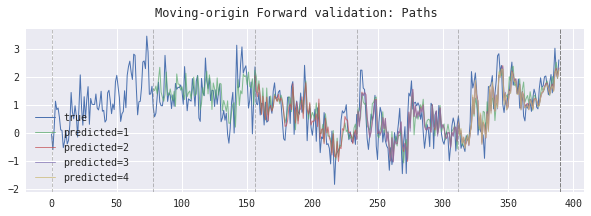

In [89]:
# -- Test run
test_mae_df, test_mse_df = experiment(
    n_iter=1,
    n_points=n_points,
    n_warmup=n_warmup,
    data_fun=data_fun,
    n_shifts=n_shifts,
    model=model,
    k_folds=k_folds,
    cv_fun=cv_fun,
    verbose=True,
)

MAE:


mean    std
0    NaN    NaN
1  0.626  0.287
2  0.521  0.081
3  0.500  0.041
4  0.490  0.052

MSE:


mean    std
1  0.690  0.880
2  0.434  0.153
3  0.398  0.063
4  0.381  0.078

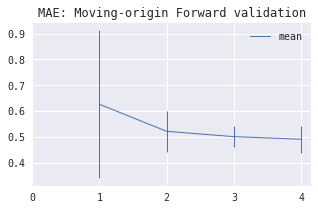

In [90]:
test_mae_df, test_mse_df = experiment(
    n_iter=n_iter,
    n_points=n_points,
    n_warmup=n_warmup,
    data_fun=data_fun,
    n_shifts=n_shifts,
    model=model,
    k_folds=k_folds,
    cv_fun=cv_fun,
    verbose=False,
)

show_results(test_mae_df, test_mse_df, cv_title)

### Blocked K-Fold CV

In [91]:
cv_fun = blocked_cv
cv_title = "Blocked K-fold CV"

2023-09-29T08:46:21.629666+0200 DEBUG 28: fold=0 coef=[0.735 -0.253 0.595 -0.342 0.169 -0.229 0.184 -0.073 0.073 0.090] mae_test=0.473
2023-09-29T08:46:21.631475+0200 DEBUG 28: fold=1 coef=[0.753 -0.229 0.478 -0.298 0.117 -0.125 0.153 -0.055 0.065 0.109] mae_test=0.476
2023-09-29T08:46:21.633899+0200 DEBUG 28: fold=2 coef=[0.748 -0.226 0.492 -0.274 0.128 -0.176 0.161 -0.045 0.066 0.100] mae_test=0.443
2023-09-29T08:46:21.635705+0200 DEBUG 28: fold=3 coef=[0.704 -0.201 0.506 -0.237 0.078 -0.121 0.095 -0.054 0.085 0.120] mae_test=0.517
2023-09-29T08:46:21.637642+0200 DEBUG 28: fold=4 coef=[0.699 -0.271 0.560 -0.293 0.139 -0.145 0.114 -0.029 0.051 0.122] mae_test=0.422


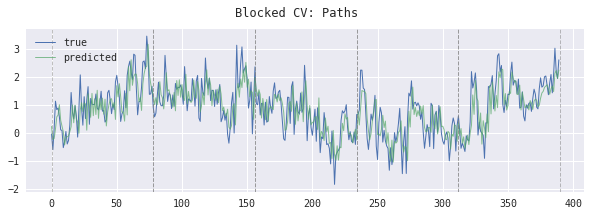

In [92]:
# -- Test run
test_mae_df, test_mse_df = experiment(
    n_iter=1,
    n_points=n_points,
    n_warmup=n_warmup,
    data_fun=data_fun,
    n_shifts=n_shifts,
    model=model,
    k_folds=k_folds,
    cv_fun=cv_fun,
    verbose=True,
)


MAE:


mean    std
0  0.488  0.043
1  0.490  0.048
2  0.489  0.051
3  0.492  0.046
4  0.490  0.052

MSE:


mean    std
0  0.377  0.065
1  0.380  0.069
2  0.377  0.073
3  0.385  0.067
4  0.381  0.078

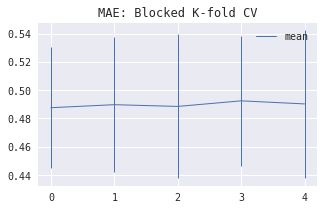

In [93]:
test_mae_df, test_mse_df = experiment(
    n_iter=n_iter,
    n_points=n_points,
    n_warmup=n_warmup,
    data_fun=data_fun,
    n_shifts=n_shifts,
    model=model,
    k_folds=k_folds,
    cv_fun=cv_fun,
    verbose=False,
)

show_results(test_mae_df, test_mse_df, cv_title)

### Combinatorial Purged CV

In [94]:
cv_fun = combinatorial_cv
cv_title = "Combinatorial CV"

2023-09-29T08:46:22.504837+0200 DEBUG 48: fold=(0, 1) coef=[0.770 -0.251 0.552 -0.372 0.167 -0.206 0.215 -0.084 0.065 0.084] mae_test=0.476
2023-09-29T08:46:22.506549+0200 DEBUG 48: fold=(0, 2) coef=[0.764 -0.248 0.573 -0.344 0.188 -0.273 0.225 -0.074 0.074 0.075] mae_test=0.458
2023-09-29T08:46:22.508752+0200 DEBUG 48: fold=(0, 3) coef=[0.697 -0.203 0.588 -0.277 0.114 -0.201 0.124 -0.075 0.087 0.110] mae_test=0.493
2023-09-29T08:46:22.511711+0200 DEBUG 48: fold=(0, 4) coef=[0.700 -0.310 0.660 -0.365 0.212 -0.242 0.167 -0.064 0.059 0.101] mae_test=0.452
2023-09-29T08:46:22.514316+0200 DEBUG 48: fold=(1, 2) coef=[0.787 -0.214 0.411 -0.269 0.122 -0.147 0.182 -0.045 0.060 0.103] mae_test=0.474
2023-09-29T08:46:22.516427+0200 DEBUG 48: fold=(1, 3) coef=[0.733 -0.184 0.431 -0.241 0.057 -0.064 0.105 -0.069 0.096 0.121] mae_test=0.502
2023-09-29T08:46:22.518549+0200 DEBUG 48: fold=(1, 4) coef=[0.718 -0.272 0.507 -0.306 0.127 -0.101 0.121 -0.026 0.046 0.127] mae_test=0.449
2023-09-29T08:46:22.

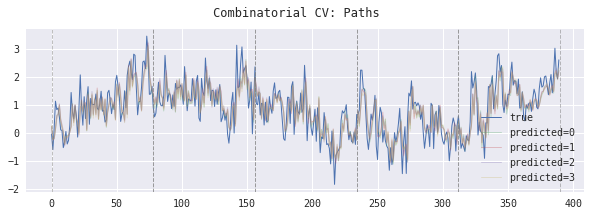

In [95]:
test_mae_df, test_mse_df = experiment(
    n_iter=1,
    n_points=n_points,
    n_warmup=n_warmup,
    data_fun=data_fun,
    n_shifts=n_shifts,
    model=model,
    k_folds=k_folds,
    cv_fun=cv_fun,
    verbose=True,
)

MAE:


mean    std
0  0.488  0.043
1  0.490  0.048
2  0.489  0.051
3  0.493  0.046
4  0.491  0.053

MSE:


mean    std
0  0.377  0.065
1  0.380  0.069
2  0.377  0.073
3  0.385  0.066
4  0.382  0.079

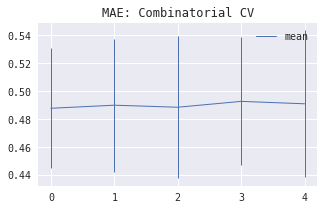

In [96]:
test_mae_df, test_mse_df = experiment(
    n_iter=n_iter,
    n_points=n_points,
    n_warmup=n_warmup,
    data_fun=data_fun,
    n_shifts=n_shifts,
    model=model,
    k_folds=k_folds,
    cv_fun=cv_fun,
    verbose=False,
)

show_results(test_mae_df, test_mse_df, "Combinatorial CV")

## Experiment 3.b: ARMA with Trend + Linear Regression (with intercept)

In [97]:
# -- Additional experiment parameters
model = LinearRegression(fit_intercept=True)
data_fun = partial(
    arma_process_data,
    ar_params=(0.3, 0.2, -0.1),
    ma_params=(0.6, -0.3, 0.5, 0.2),
    stdev=0.5,
    trend_magnitude=350.,
    trend_rate=6,
    verbose=False,
)

### Walk-forward Validation

In [98]:
cv_fun = walk_forward
cv_title = "Walk-forward validation"

2023-09-29T08:46:23.881531+0200 DEBUG 62: fold=0 coef=None mae_test=nan
2023-09-29T08:46:23.884855+0200 DEBUG 62: fold=1 coef=[0.650 -0.210 0.238 -0.113 -0.029 0.074 0.018 -0.029 0.180 0.154] mae_test=0.515
2023-09-29T08:46:23.886335+0200 DEBUG 62: fold=2 coef=[0.618 -0.240 0.466 -0.178 0.049 -0.098 0.025 -0.033 0.060 0.108] mae_test=0.478
2023-09-29T08:46:23.887836+0200 DEBUG 62: fold=3 coef=[0.639 -0.245 0.532 -0.222 0.077 -0.097 0.035 -0.033 0.054 0.132] mae_test=0.501
2023-09-29T08:46:23.890358+0200 DEBUG 62: fold=4 coef=[0.686 -0.278 0.551 -0.296 0.134 -0.150 0.109 -0.038 0.045 0.107] mae_test=0.415


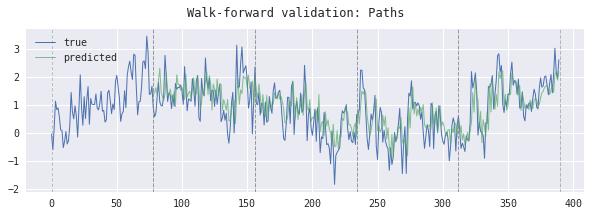

In [99]:
# -- Test run
test_mae_df, test_mse_df = experiment(
    n_iter=1,
    n_points=n_points,
    n_warmup=n_warmup,
    data_fun=data_fun,
    n_shifts=n_shifts,
    model=model,
    k_folds=k_folds,
    cv_fun=cv_fun,
    verbose=True,
)


MAE:


mean    std
0    NaN    NaN
1  0.581  0.176
2  0.523  0.128
3  0.505  0.053
4  0.492  0.056

MSE:


mean    std
1  0.550  0.368
2  0.440  0.286
3  0.404  0.079
4  0.384  0.083

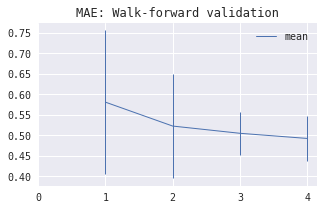

In [100]:
test_mae_df, test_mse_df = experiment(
    n_iter=n_iter,
    n_points=n_points,
    n_warmup=n_warmup,
    data_fun=data_fun,
    n_shifts=n_shifts,
    model=model,
    k_folds=k_folds,
    cv_fun=cv_fun,
    verbose=False,
)

show_results(test_mae_df, test_mse_df, cv_title)

### Moving-origin Forward Validation

In [101]:
cv_fun = partial(walk_forward, unbounded_fold=True)
cv_title = "Moving-origin Forward validation"

2023-09-29T08:46:24.828048+0200 DEBUG 62: fold=0 coef=None mae_test=nan
2023-09-29T08:46:24.829571+0200 DEBUG 62: fold=1 coef=[0.650 -0.210 0.238 -0.113 -0.029 0.074 0.018 -0.029 0.180 0.154] mae_test=0.517
2023-09-29T08:46:24.831122+0200 DEBUG 62: fold=2 coef=[0.618 -0.240 0.466 -0.178 0.049 -0.098 0.025 -0.033 0.060 0.108] mae_test=0.473
2023-09-29T08:46:24.832470+0200 DEBUG 62: fold=3 coef=[0.639 -0.245 0.532 -0.222 0.077 -0.097 0.035 -0.033 0.054 0.132] mae_test=0.459
2023-09-29T08:46:24.834542+0200 DEBUG 62: fold=4 coef=[0.686 -0.278 0.551 -0.296 0.134 -0.150 0.109 -0.038 0.045 0.107] mae_test=0.415


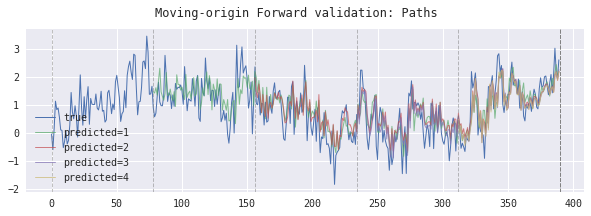

In [102]:
# -- Test run
test_mae_df, test_mse_df = experiment(
    n_iter=1,
    n_points=n_points,
    n_warmup=n_warmup,
    data_fun=data_fun,
    n_shifts=n_shifts,
    model=model,
    k_folds=k_folds,
    cv_fun=cv_fun,
    verbose=True,
)

MAE:


mean    std
0    NaN    NaN
1  0.711  0.369
2  0.554  0.185
3  0.509  0.048
4  0.492  0.056

MSE:


mean    std
1  0.904  1.120
2  0.511  0.524
3  0.410  0.075
4  0.384  0.083

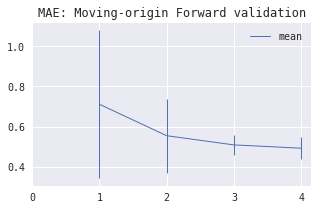

In [103]:
test_mae_df, test_mse_df = experiment(
    n_iter=n_iter,
    n_points=n_points,
    n_warmup=n_warmup,
    data_fun=data_fun,
    n_shifts=n_shifts,
    model=model,
    k_folds=k_folds,
    cv_fun=cv_fun,
    verbose=False,
)

show_results(test_mae_df, test_mse_df, cv_title)

### Blocked K-Fold CV

In [104]:
cv_fun = blocked_cv
cv_title = "Blocked K-fold CV"

2023-09-29T08:46:25.692356+0200 DEBUG 28: fold=0 coef=[0.718 -0.260 0.585 -0.346 0.164 -0.234 0.181 -0.083 0.066 0.073] mae_test=0.469
2023-09-29T08:46:25.695149+0200 DEBUG 28: fold=1 coef=[0.737 -0.234 0.471 -0.301 0.109 -0.131 0.149 -0.063 0.059 0.095] mae_test=0.471
2023-09-29T08:46:25.697649+0200 DEBUG 28: fold=2 coef=[0.721 -0.234 0.478 -0.277 0.119 -0.183 0.154 -0.056 0.058 0.079] mae_test=0.454
2023-09-29T08:46:25.699871+0200 DEBUG 28: fold=3 coef=[0.678 -0.208 0.493 -0.241 0.068 -0.130 0.089 -0.065 0.075 0.103] mae_test=0.499
2023-09-29T08:46:25.702110+0200 DEBUG 28: fold=4 coef=[0.686 -0.278 0.551 -0.296 0.134 -0.150 0.109 -0.038 0.045 0.107] mae_test=0.415


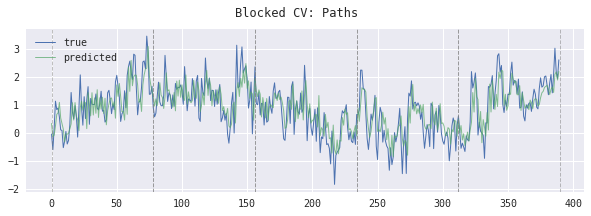

In [105]:
# -- Test run
test_mae_df, test_mse_df = experiment(
    n_iter=1,
    n_points=n_points,
    n_warmup=n_warmup,
    data_fun=data_fun,
    n_shifts=n_shifts,
    model=model,
    k_folds=k_folds,
    cv_fun=cv_fun,
    verbose=True,
)


MAE:


mean    std
0  0.499  0.051
1  0.489  0.048
2  0.487  0.051
3  0.492  0.047
4  0.492  0.056

MSE:


mean    std
0  0.395  0.080
1  0.378  0.069
2  0.374  0.073
3  0.383  0.068
4  0.384  0.083

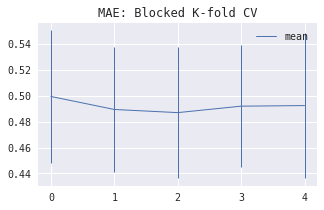

In [106]:
test_mae_df, test_mse_df = experiment(
    n_iter=n_iter,
    n_points=n_points,
    n_warmup=n_warmup,
    data_fun=data_fun,
    n_shifts=n_shifts,
    model=model,
    k_folds=k_folds,
    cv_fun=cv_fun,
    verbose=False,
)

show_results(test_mae_df, test_mse_df, cv_title)

### Combinatorial Purged CV

In [107]:
cv_fun = combinatorial_cv
cv_title = "Combinatorial CV"

2023-09-29T08:46:26.641510+0200 DEBUG 48: fold=(0, 1) coef=[0.757 -0.257 0.546 -0.376 0.161 -0.211 0.212 -0.091 0.059 0.070] mae_test=0.472
2023-09-29T08:46:26.643719+0200 DEBUG 48: fold=(0, 2) coef=[0.737 -0.256 0.560 -0.348 0.182 -0.278 0.221 -0.085 0.067 0.052] mae_test=0.461
2023-09-29T08:46:26.647123+0200 DEBUG 48: fold=(0, 3) coef=[0.674 -0.211 0.575 -0.282 0.107 -0.208 0.120 -0.086 0.078 0.091] mae_test=0.483
2023-09-29T08:46:26.649668+0200 DEBUG 48: fold=(0, 4) coef=[0.689 -0.316 0.651 -0.369 0.210 -0.246 0.165 -0.073 0.054 0.086] mae_test=0.449
2023-09-29T08:46:26.651935+0200 DEBUG 48: fold=(1, 2) coef=[0.764 -0.220 0.401 -0.272 0.113 -0.153 0.176 -0.054 0.053 0.086] mae_test=0.472
2023-09-29T08:46:26.654189+0200 DEBUG 48: fold=(1, 3) coef=[0.714 -0.189 0.423 -0.244 0.047 -0.072 0.099 -0.077 0.089 0.110] mae_test=0.492
2023-09-29T08:46:26.655871+0200 DEBUG 48: fold=(1, 4) coef=[0.709 -0.278 0.501 -0.309 0.122 -0.106 0.117 -0.033 0.041 0.115] mae_test=0.445
2023-09-29T08:46:26.

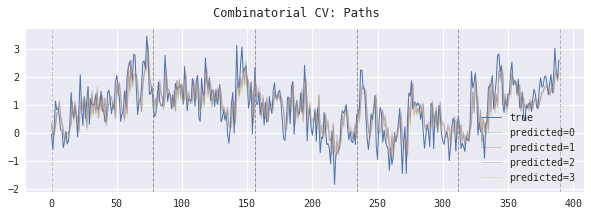

In [108]:
test_mae_df, test_mse_df = experiment(
    n_iter=1,
    n_points=n_points,
    n_warmup=n_warmup,
    data_fun=data_fun,
    n_shifts=n_shifts,
    model=model,
    k_folds=k_folds,
    cv_fun=cv_fun,
    verbose=True,
)

MAE:


mean    std
0  0.504  0.053
1  0.491  0.049
2  0.487  0.051
3  0.493  0.048
4  0.495  0.057

MSE:


mean    std
0  0.402  0.085
1  0.379  0.070
2  0.374  0.073
3  0.385  0.069
4  0.388  0.087

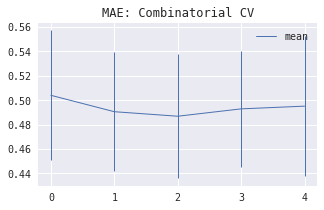

In [109]:
test_mae_df, test_mse_df = experiment(
    n_iter=n_iter,
    n_points=n_points,
    n_warmup=n_warmup,
    data_fun=data_fun,
    n_shifts=n_shifts,
    model=model,
    k_folds=k_folds,
    cv_fun=cv_fun,
    verbose=False,
)

show_results(test_mae_df, test_mse_df, "Combinatorial CV")

## Experiment 3.c: ARMA with Trend + Gradient Boosting

In [110]:
# -- Additional experiment parameters
base_model = LGBMRegressor(
    learning_rate=0.02,
    n_estimators=200,
    num_leaves=4,
    min_child_samples=5,
    reg_alpha=0.1,
    force_col_wise=True,
    verbose=-1,
)
model = LGBMRegressorEarlyStop(
    regressor=base_model,
    eval_ratio=0.2,
    eval_metric="l2",
    stopping_rounds=5,
)

data_fun = partial(
    arma_process_data,
    ar_params=(0.3, 0.2, -0.1),
    ma_params=(0.6, -0.3, 0.5, 0.2),
    stdev=0.5,
    trend_magnitude=350.,
    trend_rate=6,
    verbose=False,
)

### Walk-forward Validation

In [111]:
cv_fun = walk_forward
cv_title = "Walk-forward validation"

2023-09-29T08:46:28.157186+0200 DEBUG 62: fold=0 coef=None mae_test=nan
2023-09-29T08:46:28.172385+0200 DEBUG 62: fold=1 coef=None mae_test=0.565
2023-09-29T08:46:28.180404+0200 DEBUG 62: fold=2 coef=None mae_test=0.686
2023-09-29T08:46:28.200679+0200 DEBUG 62: fold=3 coef=None mae_test=0.574
2023-09-29T08:46:28.220444+0200 DEBUG 62: fold=4 coef=None mae_test=0.475


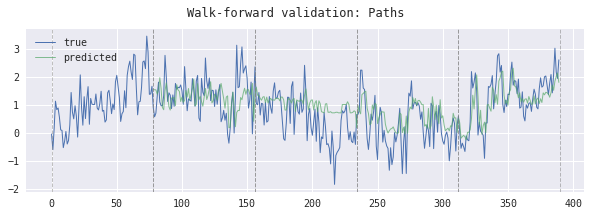

In [112]:
# -- Test run
test_mae_df, test_mse_df = experiment(
    n_iter=1,
    n_points=n_points,
    n_warmup=n_warmup,
    data_fun=data_fun,
    n_shifts=n_shifts,
    model=model,
    k_folds=k_folds,
    cv_fun=cv_fun,
    verbose=True,
)


MAE:


mean    std
0    NaN    NaN
1  1.080  0.585
2  0.906  0.500
3  0.884  0.582
4  0.852  0.531

MSE:


mean    std
1  2.017  2.086
2  1.463  1.632
3  1.473  2.232
4  1.338  1.714

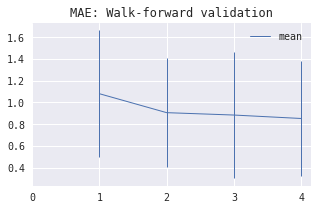

In [113]:
test_mae_df, test_mse_df = experiment(
    n_iter=n_iter,
    n_points=n_points,
    n_warmup=n_warmup,
    data_fun=data_fun,
    n_shifts=n_shifts,
    model=model,
    k_folds=k_folds,
    cv_fun=cv_fun,
    verbose=False,
)

show_results(test_mae_df, test_mse_df, cv_title)

### Moving-origin Forward Validation

In [114]:
cv_fun = partial(walk_forward, unbounded_fold=True)
cv_title = "Moving-origin Forward validation"

2023-09-29T08:46:35.293896+0200 DEBUG 62: fold=0 coef=None mae_test=nan
2023-09-29T08:46:35.311418+0200 DEBUG 62: fold=1 coef=None mae_test=0.559
2023-09-29T08:46:35.318960+0200 DEBUG 62: fold=2 coef=None mae_test=0.703
2023-09-29T08:46:35.345728+0200 DEBUG 62: fold=3 coef=None mae_test=0.533
2023-09-29T08:46:35.371842+0200 DEBUG 62: fold=4 coef=None mae_test=0.475


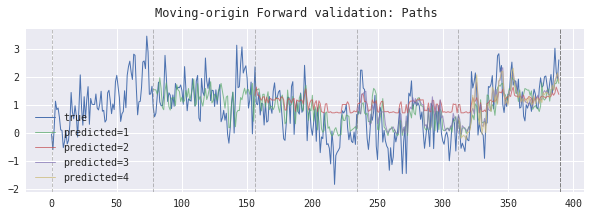

In [115]:
# -- Test run
test_mae_df, test_mse_df = experiment(
    n_iter=1,
    n_points=n_points,
    n_warmup=n_warmup,
    data_fun=data_fun,
    n_shifts=n_shifts,
    model=model,
    k_folds=k_folds,
    cv_fun=cv_fun,
    verbose=True,
)

MAE:


mean    std
0    NaN    NaN
1  1.564  0.983
2  1.216  0.766
3  1.003  0.682
4  0.852  0.531

MSE:


mean    std
1  4.524  5.698
2  2.806  3.427
3  1.946  2.837
4  1.338  1.714

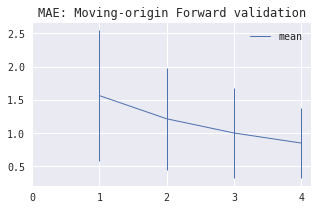

In [116]:
test_mae_df, test_mse_df = experiment(
    n_iter=n_iter,
    n_points=n_points,
    n_warmup=n_warmup,
    data_fun=data_fun,
    n_shifts=n_shifts,
    model=model,
    k_folds=k_folds,
    cv_fun=cv_fun,
    verbose=False,
)

show_results(test_mae_df, test_mse_df, cv_title)

### Blocked K-Fold CV

In [117]:
cv_fun = blocked_cv
cv_title = "Blocked K-fold CV"

2023-09-29T08:46:42.278488+0200 DEBUG 28: fold=0 coef=None mae_test=0.516
2023-09-29T08:46:42.297188+0200 DEBUG 28: fold=1 coef=None mae_test=0.537
2023-09-29T08:46:42.314022+0200 DEBUG 28: fold=2 coef=None mae_test=0.498
2023-09-29T08:46:42.329868+0200 DEBUG 28: fold=3 coef=None mae_test=0.534
2023-09-29T08:46:42.353862+0200 DEBUG 28: fold=4 coef=None mae_test=0.475


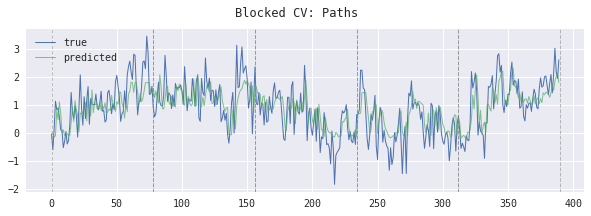

In [118]:
# -- Test run
test_mae_df, test_mse_df = experiment(
    n_iter=1,
    n_points=n_points,
    n_warmup=n_warmup,
    data_fun=data_fun,
    n_shifts=n_shifts,
    model=model,
    k_folds=k_folds,
    cv_fun=cv_fun,
    verbose=True,
)


MAE:


mean    std
0  0.788  0.381
1  0.597  0.156
2  0.568  0.110
3  0.607  0.142
4  0.852  0.531

MSE:


mean    std
0  1.115  1.163
1  0.591  0.360
2  0.522  0.219
3  0.602  0.327
4  1.338  1.714

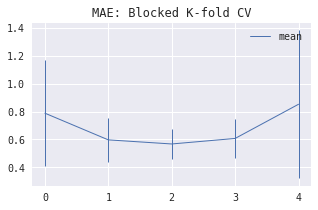

In [119]:
test_mae_df, test_mse_df = experiment(
    n_iter=n_iter,
    n_points=n_points,
    n_warmup=n_warmup,
    data_fun=data_fun,
    n_shifts=n_shifts,
    model=model,
    k_folds=k_folds,
    cv_fun=cv_fun,
    verbose=False,
)

show_results(test_mae_df, test_mse_df, cv_title)

### Combinatorial Purged CV

In [120]:
cv_fun = combinatorial_cv
cv_title = "Combinatorial CV"

2023-09-29T08:46:51.964757+0200 DEBUG 48: fold=(0, 1) coef=None mae_test=0.564
2023-09-29T08:46:51.981349+0200 DEBUG 48: fold=(0, 2) coef=None mae_test=0.508
2023-09-29T08:46:52.001529+0200 DEBUG 48: fold=(0, 3) coef=None mae_test=0.513
2023-09-29T08:46:52.014531+0200 DEBUG 48: fold=(0, 4) coef=None mae_test=0.526
2023-09-29T08:46:52.030983+0200 DEBUG 48: fold=(1, 2) coef=None mae_test=0.515
2023-09-29T08:46:52.047912+0200 DEBUG 48: fold=(1, 3) coef=None mae_test=0.555
2023-09-29T08:46:52.060020+0200 DEBUG 48: fold=(1, 4) coef=None mae_test=0.528
2023-09-29T08:46:52.074654+0200 DEBUG 48: fold=(2, 3) coef=None mae_test=0.567
2023-09-29T08:46:52.089678+0200 DEBUG 48: fold=(2, 4) coef=None mae_test=0.495
2023-09-29T08:46:52.111322+0200 DEBUG 48: fold=(3, 4) coef=None mae_test=0.533


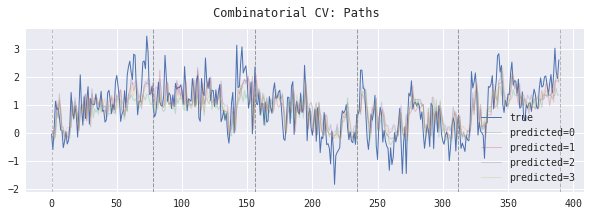

In [121]:
test_mae_df, test_mse_df = experiment(
    n_iter=1,
    n_points=n_points,
    n_warmup=n_warmup,
    data_fun=data_fun,
    n_shifts=n_shifts,
    model=model,
    k_folds=k_folds,
    cv_fun=cv_fun,
    verbose=True,
)

MAE:


mean    std
0  0.864  0.451
1  0.611  0.159
2  0.574  0.127
3  0.636  0.170
4  0.867  0.498

MSE:


mean    std
0  1.325  1.413
1  0.615  0.359
2  0.537  0.270
3  0.660  0.372
4  1.336  1.543

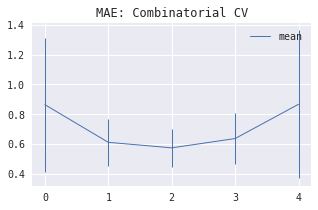

In [122]:
test_mae_df, test_mse_df = experiment(
    n_iter=n_iter,
    n_points=n_points,
    n_warmup=n_warmup,
    data_fun=data_fun,
    n_shifts=n_shifts,
    model=model,
    k_folds=k_folds,
    cv_fun=cv_fun,
    verbose=False,
)

show_results(test_mae_df, test_mse_df, "Combinatorial CV")

## Experiment 4.a: Nonlinear ARMA + Linear Regression

In [123]:
# -- Additional experiment parameters
model = LinearRegression(fit_intercept=False)

data_fun = partial(
    ar_garch_process_data,
    transformation=partial(nonlinear_sin, pos_factor=0.5, neg_factor=10),
    stdev=0.5,
    verbose=False,
)

### Walk-forward Validation

In [124]:
cv_fun = walk_forward
cv_title = "Walk-forward validation"

2023-09-29T08:47:11.590535+0200 DEBUG 62: fold=0 coef=None mae_test=nan
2023-09-29T08:47:11.592867+0200 DEBUG 62: fold=1 coef=[0.356 0.205 -0.322 0.084 -0.163 0.119 0.039 -0.203 0.154 0.019] mae_test=0.366
2023-09-29T08:47:11.594382+0200 DEBUG 62: fold=2 coef=[0.156 0.160 0.023 -0.057 -0.084 0.046 -0.037 -0.029 -0.031 0.019] mae_test=0.294
2023-09-29T08:47:11.597517+0200 DEBUG 62: fold=3 coef=[0.174 0.179 0.081 -0.061 -0.096 0.088 -0.027 -0.022 -0.007 0.046] mae_test=0.294
2023-09-29T08:47:11.599688+0200 DEBUG 62: fold=4 coef=[0.190 0.138 0.075 -0.101 -0.060 0.059 0.004 -0.006 -0.035 0.042] mae_test=0.253


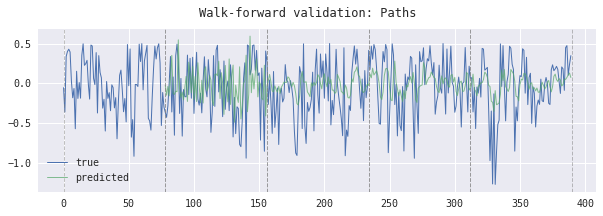

In [125]:
# -- Test run
test_mae_df, test_mse_df = experiment(
    n_iter=1,
    n_points=n_points,
    n_warmup=n_warmup,
    data_fun=data_fun,
    n_shifts=n_shifts,
    model=model,
    k_folds=k_folds,
    cv_fun=cv_fun,
    verbose=True,
)


MAE:


mean    std
0    NaN    NaN
1  0.316  0.037
2  0.302  0.033
3  0.296  0.031
4  0.293  0.030

MSE:


mean    std
1  0.155  0.039
2  0.141  0.031
3  0.134  0.031
4  0.133  0.029

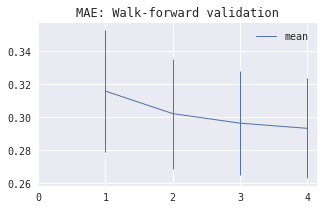

In [126]:
test_mae_df, test_mse_df = experiment(
    n_iter=n_iter,
    n_points=n_points,
    n_warmup=n_warmup,
    data_fun=data_fun,
    n_shifts=n_shifts,
    model=model,
    k_folds=k_folds,
    cv_fun=cv_fun,
    verbose=False,
)

show_results(test_mae_df, test_mse_df, cv_title)

### Moving-origin Forward Validation

In [127]:
cv_fun = partial(walk_forward, unbounded_fold=True)
cv_title = "Moving-origin Forward validation"

2023-09-29T08:47:12.845256+0200 DEBUG 62: fold=0 coef=None mae_test=nan
2023-09-29T08:47:12.848021+0200 DEBUG 62: fold=1 coef=[0.356 0.205 -0.322 0.084 -0.163 0.119 0.039 -0.203 0.154 0.019] mae_test=0.330
2023-09-29T08:47:12.850128+0200 DEBUG 62: fold=2 coef=[0.156 0.160 0.023 -0.057 -0.084 0.046 -0.037 -0.029 -0.031 0.019] mae_test=0.279
2023-09-29T08:47:12.852372+0200 DEBUG 62: fold=3 coef=[0.174 0.179 0.081 -0.061 -0.096 0.088 -0.027 -0.022 -0.007 0.046] mae_test=0.273
2023-09-29T08:47:12.855214+0200 DEBUG 62: fold=4 coef=[0.190 0.138 0.075 -0.101 -0.060 0.059 0.004 -0.006 -0.035 0.042] mae_test=0.253


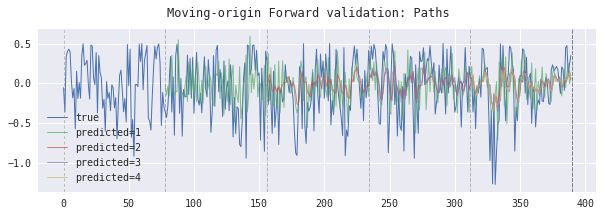

In [128]:
# -- Test run
test_mae_df, test_mse_df = experiment(
    n_iter=1,
    n_points=n_points,
    n_warmup=n_warmup,
    data_fun=data_fun,
    n_shifts=n_shifts,
    model=model,
    k_folds=k_folds,
    cv_fun=cv_fun,
    verbose=True,
)

MAE:


mean    std
0    NaN    NaN
1  0.311  0.022
2  0.299  0.019
3  0.296  0.023
4  0.293  0.030

MSE:


mean    std
1  0.150  0.023
2  0.138  0.018
3  0.134  0.022
4  0.133  0.029

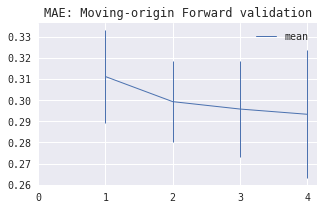

In [129]:
test_mae_df, test_mse_df = experiment(
    n_iter=n_iter,
    n_points=n_points,
    n_warmup=n_warmup,
    data_fun=data_fun,
    n_shifts=n_shifts,
    model=model,
    k_folds=k_folds,
    cv_fun=cv_fun,
    verbose=False,
)

show_results(test_mae_df, test_mse_df, cv_title)

### Blocked K-Fold CV

In [130]:
cv_fun = blocked_cv
cv_title = "Blocked K-fold CV"

2023-09-29T08:47:14.017544+0200 DEBUG 28: fold=0 coef=[0.200 0.175 0.142 -0.133 -0.033 0.004 0.033 -0.004 -0.056 0.017] mae_test=0.281
2023-09-29T08:47:14.019543+0200 DEBUG 28: fold=1 coef=[0.259 0.209 0.017 -0.136 -0.041 0.052 0.040 -0.036 -0.027 0.033] mae_test=0.310
2023-09-29T08:47:14.020747+0200 DEBUG 28: fold=2 coef=[0.218 0.184 0.031 -0.126 -0.020 -0.012 0.026 -0.009 -0.067 0.008] mae_test=0.299
2023-09-29T08:47:14.022924+0200 DEBUG 28: fold=3 coef=[0.202 0.234 0.073 -0.097 -0.075 0.051 0.001 -0.030 -0.024 0.029] mae_test=0.292
2023-09-29T08:47:14.024468+0200 DEBUG 28: fold=4 coef=[0.190 0.138 0.075 -0.101 -0.060 0.059 0.004 -0.006 -0.035 0.042] mae_test=0.253


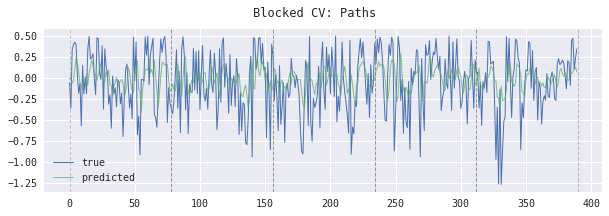

In [131]:
# -- Test run
test_mae_df, test_mse_df = experiment(
    n_iter=1,
    n_points=n_points,
    n_warmup=n_warmup,
    data_fun=data_fun,
    n_shifts=n_shifts,
    model=model,
    k_folds=k_folds,
    cv_fun=cv_fun,
    verbose=True,
)


MAE:


mean    std
0  0.295  0.031
1  0.302  0.035
2  0.298  0.033
3  0.294  0.030
4  0.293  0.030

MSE:


mean    std
0  0.135  0.029
1  0.140  0.034
2  0.137  0.030
3  0.133  0.030
4  0.133  0.029

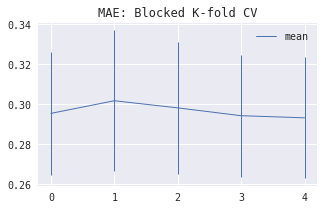

In [132]:
test_mae_df, test_mse_df = experiment(
    n_iter=n_iter,
    n_points=n_points,
    n_warmup=n_warmup,
    data_fun=data_fun,
    n_shifts=n_shifts,
    model=model,
    k_folds=k_folds,
    cv_fun=cv_fun,
    verbose=False,
)

show_results(test_mae_df, test_mse_df, cv_title)

### Combinatorial Purged CV

In [133]:
cv_fun = combinatorial_cv
cv_title = "Combinatorial CV"

2023-09-29T08:47:15.261339+0200 DEBUG 48: fold=(0, 1) coef=[0.256 0.192 0.105 -0.171 -0.022 0.017 0.067 -0.023 -0.042 0.018] mae_test=0.293
2023-09-29T08:47:15.263792+0200 DEBUG 48: fold=(0, 2) coef=[0.205 0.161 0.121 -0.151 0.007 -0.056 0.046 0.004 -0.085 -0.012] mae_test=0.293
2023-09-29T08:47:15.266292+0200 DEBUG 48: fold=(0, 3) coef=[0.171 0.234 0.172 -0.100 -0.071 0.013 0.003 -0.010 -0.040 0.025] mae_test=0.289
2023-09-29T08:47:15.268167+0200 DEBUG 48: fold=(0, 4) coef=[0.168 0.108 0.164 -0.111 -0.036 0.030 0.014 0.013 -0.056 0.039] mae_test=0.269
2023-09-29T08:47:15.269981+0200 DEBUG 48: fold=(1, 2) coef=[0.286 0.212 -0.061 -0.138 0.007 -0.018 0.055 -0.026 -0.059 0.016] mae_test=0.311
2023-09-29T08:47:15.271602+0200 DEBUG 48: fold=(1, 3) coef=[0.264 0.279 -0.006 -0.117 -0.075 0.092 0.021 -0.065 0.004 0.038] mae_test=0.302
2023-09-29T08:47:15.273273+0200 DEBUG 48: fold=(1, 4) coef=[0.238 0.149 0.012 -0.115 -0.061 0.090 0.023 -0.027 -0.005 0.055] mae_test=0.283
2023-09-29T08:47:15.

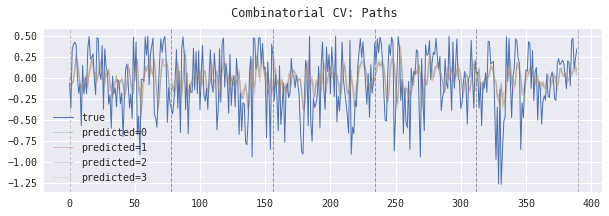

In [134]:
test_mae_df, test_mse_df = experiment(
    n_iter=1,
    n_points=n_points,
    n_warmup=n_warmup,
    data_fun=data_fun,
    n_shifts=n_shifts,
    model=model,
    k_folds=k_folds,
    cv_fun=cv_fun,
    verbose=True,
)

MAE:


mean    std
0  0.295  0.031
1  0.302  0.035
2  0.298  0.033
3  0.294  0.031
4  0.293  0.030

MSE:


mean    std
0  0.135  0.029
1  0.140  0.034
2  0.137  0.030
3  0.132  0.030
4  0.133  0.029

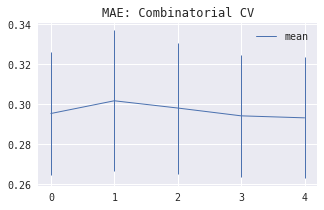

In [135]:
test_mae_df, test_mse_df = experiment(
    n_iter=n_iter,
    n_points=n_points,
    n_warmup=n_warmup,
    data_fun=data_fun,
    n_shifts=n_shifts,
    model=model,
    k_folds=k_folds,
    cv_fun=cv_fun,
    verbose=False,
)

show_results(test_mae_df, test_mse_df, "Combinatorial CV")

## Experiment 4.b: Nonlinear ARMA + Linear Regression (with intercept)

In [136]:
# -- Additional experiment parameters
model = LinearRegression(fit_intercept=True)

data_fun = partial(
    ar_garch_process_data,
    transformation=partial(nonlinear_sin, pos_factor=0.5, neg_factor=10),
    stdev=0.5,
    verbose=False,
)

### Walk-forward Validation

In [137]:
cv_fun = walk_forward
cv_title = "Walk-forward validation"

2023-09-29T08:47:17.066754+0200 DEBUG 62: fold=0 coef=None mae_test=nan
2023-09-29T08:47:17.069230+0200 DEBUG 62: fold=1 coef=[0.356 0.204 -0.322 0.085 -0.163 0.119 0.039 -0.203 0.154 0.018] mae_test=0.366
2023-09-29T08:47:17.071447+0200 DEBUG 62: fold=2 coef=[0.149 0.155 0.019 -0.061 -0.088 0.042 -0.040 -0.033 -0.037 0.012] mae_test=0.289
2023-09-29T08:47:17.073153+0200 DEBUG 62: fold=3 coef=[0.154 0.163 0.068 -0.072 -0.110 0.076 -0.036 -0.034 -0.024 0.025] mae_test=0.303
2023-09-29T08:47:17.074778+0200 DEBUG 62: fold=4 coef=[0.180 0.130 0.068 -0.108 -0.068 0.051 -0.002 -0.012 -0.043 0.032] mae_test=0.260


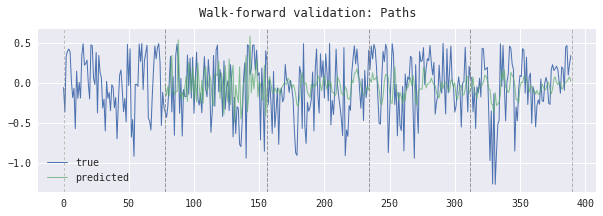

In [138]:
# -- Test run
test_mae_df, test_mse_df = experiment(
    n_iter=1,
    n_points=n_points,
    n_warmup=n_warmup,
    data_fun=data_fun,
    n_shifts=n_shifts,
    model=model,
    k_folds=k_folds,
    cv_fun=cv_fun,
    verbose=True,
)


MAE:


mean    std
0    NaN    NaN
1  0.320  0.036
2  0.304  0.033
3  0.299  0.031
4  0.295  0.030

MSE:


mean    std
1  0.156  0.038
2  0.140  0.029
3  0.134  0.030
4  0.132  0.028

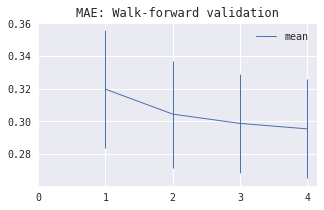

In [139]:
test_mae_df, test_mse_df = experiment(
    n_iter=n_iter,
    n_points=n_points,
    n_warmup=n_warmup,
    data_fun=data_fun,
    n_shifts=n_shifts,
    model=model,
    k_folds=k_folds,
    cv_fun=cv_fun,
    verbose=False,
)

show_results(test_mae_df, test_mse_df, cv_title)

### Moving-origin Forward Validation

In [140]:
cv_fun = partial(walk_forward, unbounded_fold=True)
cv_title = "Moving-origin Forward validation"

2023-09-29T08:47:18.256613+0200 DEBUG 62: fold=0 coef=None mae_test=nan
2023-09-29T08:47:18.259173+0200 DEBUG 62: fold=1 coef=[0.356 0.204 -0.322 0.085 -0.163 0.119 0.039 -0.203 0.154 0.018] mae_test=0.330
2023-09-29T08:47:18.261504+0200 DEBUG 62: fold=2 coef=[0.149 0.155 0.019 -0.061 -0.088 0.042 -0.040 -0.033 -0.037 0.012] mae_test=0.281
2023-09-29T08:47:18.263449+0200 DEBUG 62: fold=3 coef=[0.154 0.163 0.068 -0.072 -0.110 0.076 -0.036 -0.034 -0.024 0.025] mae_test=0.283
2023-09-29T08:47:18.265702+0200 DEBUG 62: fold=4 coef=[0.180 0.130 0.068 -0.108 -0.068 0.051 -0.002 -0.012 -0.043 0.032] mae_test=0.260


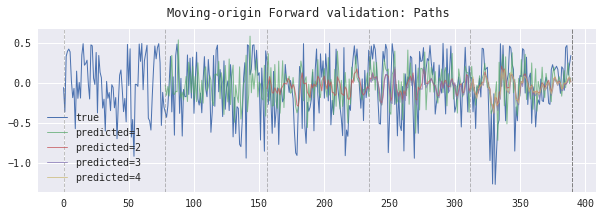

In [141]:
# -- Test run
test_mae_df, test_mse_df = experiment(
    n_iter=1,
    n_points=n_points,
    n_warmup=n_warmup,
    data_fun=data_fun,
    n_shifts=n_shifts,
    model=model,
    k_folds=k_folds,
    cv_fun=cv_fun,
    verbose=True,
)

MAE:


mean    std
0    NaN    NaN
1  0.315  0.022
2  0.302  0.019
3  0.298  0.023
4  0.295  0.030

MSE:


mean    std
1  0.152  0.022
2  0.138  0.018
3  0.134  0.021
4  0.132  0.028

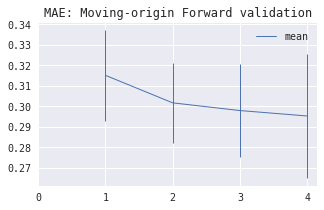

In [142]:
test_mae_df, test_mse_df = experiment(
    n_iter=n_iter,
    n_points=n_points,
    n_warmup=n_warmup,
    data_fun=data_fun,
    n_shifts=n_shifts,
    model=model,
    k_folds=k_folds,
    cv_fun=cv_fun,
    verbose=False,
)

show_results(test_mae_df, test_mse_df, cv_title)

### Blocked K-Fold CV

In [143]:
cv_fun = blocked_cv
cv_title = "Blocked K-fold CV"

2023-09-29T08:47:19.476985+0200 DEBUG 28: fold=0 coef=[0.185 0.163 0.132 -0.142 -0.044 -0.006 0.026 -0.014 -0.067 0.001] mae_test=0.283
2023-09-29T08:47:19.479818+0200 DEBUG 28: fold=1 coef=[0.251 0.202 0.013 -0.141 -0.048 0.045 0.035 -0.042 -0.035 0.023] mae_test=0.308
2023-09-29T08:47:19.482645+0200 DEBUG 28: fold=2 coef=[0.213 0.181 0.029 -0.129 -0.023 -0.015 0.023 -0.012 -0.071 0.003] mae_test=0.295
2023-09-29T08:47:19.485477+0200 DEBUG 28: fold=3 coef=[0.185 0.220 0.063 -0.106 -0.086 0.041 -0.008 -0.040 -0.039 0.010] mae_test=0.300
2023-09-29T08:47:19.487717+0200 DEBUG 28: fold=4 coef=[0.180 0.130 0.068 -0.108 -0.068 0.051 -0.002 -0.012 -0.043 0.032] mae_test=0.260


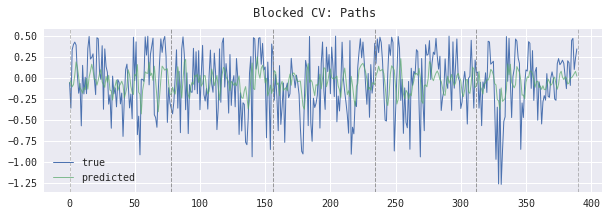

In [144]:
# -- Test run
test_mae_df, test_mse_df = experiment(
    n_iter=1,
    n_points=n_points,
    n_warmup=n_warmup,
    data_fun=data_fun,
    n_shifts=n_shifts,
    model=model,
    k_folds=k_folds,
    cv_fun=cv_fun,
    verbose=True,
)


MAE:


mean    std
0  0.297  0.030
1  0.303  0.034
2  0.300  0.032
3  0.296  0.029
4  0.295  0.030

MSE:


mean    std
0  0.133  0.028
1  0.139  0.033
2  0.136  0.028
3  0.132  0.029
4  0.132  0.028

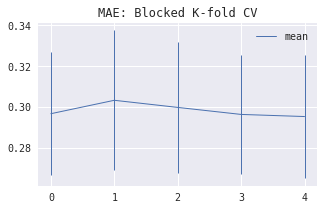

In [145]:
test_mae_df, test_mse_df = experiment(
    n_iter=n_iter,
    n_points=n_points,
    n_warmup=n_warmup,
    data_fun=data_fun,
    n_shifts=n_shifts,
    model=model,
    k_folds=k_folds,
    cv_fun=cv_fun,
    verbose=False,
)

show_results(test_mae_df, test_mse_df, cv_title)

### Combinatorial Purged CV

In [146]:
cv_fun = combinatorial_cv
cv_title = "Combinatorial CV"

2023-09-29T08:47:20.747320+0200 DEBUG 48: fold=(0, 1) coef=[0.243 0.182 0.097 -0.178 -0.033 0.007 0.060 -0.031 -0.053 0.003] mae_test=0.293
2023-09-29T08:47:20.750100+0200 DEBUG 48: fold=(0, 2) coef=[0.198 0.156 0.117 -0.156 0.002 -0.061 0.042 -0.001 -0.090 -0.020] mae_test=0.291
2023-09-29T08:47:20.752254+0200 DEBUG 48: fold=(0, 3) coef=[0.142 0.210 0.152 -0.114 -0.087 -0.001 -0.009 -0.026 -0.064 -0.007] mae_test=0.297
2023-09-29T08:47:20.754190+0200 DEBUG 48: fold=(0, 4) coef=[0.151 0.095 0.152 -0.122 -0.048 0.018 0.005 0.003 -0.068 0.023] mae_test=0.276
2023-09-29T08:47:20.755934+0200 DEBUG 48: fold=(1, 2) coef=[0.284 0.211 -0.062 -0.139 0.005 -0.019 0.054 -0.027 -0.060 0.014] mae_test=0.310
2023-09-29T08:47:20.757844+0200 DEBUG 48: fold=(1, 3) coef=[0.249 0.265 -0.013 -0.124 -0.088 0.081 0.012 -0.074 -0.012 0.020] mae_test=0.306
2023-09-29T08:47:20.759799+0200 DEBUG 48: fold=(1, 4) coef=[0.231 0.143 0.008 -0.119 -0.068 0.083 0.018 -0.031 -0.012 0.047] mae_test=0.284
2023-09-29T08:4

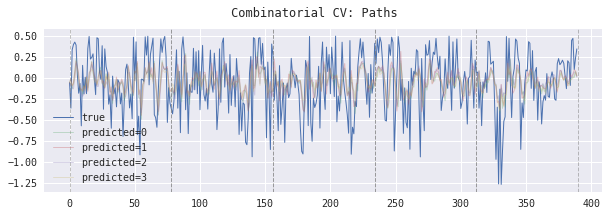

In [147]:
test_mae_df, test_mse_df = experiment(
    n_iter=1,
    n_points=n_points,
    n_warmup=n_warmup,
    data_fun=data_fun,
    n_shifts=n_shifts,
    model=model,
    k_folds=k_folds,
    cv_fun=cv_fun,
    verbose=True,
)

MAE:


mean    std
0  0.297  0.030
1  0.303  0.035
2  0.300  0.032
3  0.296  0.029
4  0.295  0.030

MSE:


mean    std
0  0.133  0.028
1  0.139  0.033
2  0.136  0.028
3  0.132  0.029
4  0.132  0.028

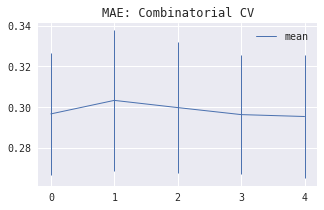

In [148]:
test_mae_df, test_mse_df = experiment(
    n_iter=n_iter,
    n_points=n_points,
    n_warmup=n_warmup,
    data_fun=data_fun,
    n_shifts=n_shifts,
    model=model,
    k_folds=k_folds,
    cv_fun=cv_fun,
    verbose=False,
)

show_results(test_mae_df, test_mse_df, "Combinatorial CV")

## Experiment 4.c: Nonlinear AR + Gradient Boosting

In [149]:
# -- Additional experiment parameters
base_model = LGBMRegressor(
    learning_rate=0.02,
    n_estimators=200,
    num_leaves=4,
    min_child_samples=5,
    reg_alpha=0.1,
    force_col_wise=True,
    verbose=-1,
)
model = LGBMRegressorEarlyStop(
    regressor=base_model,
    eval_ratio=0.2,
    eval_metric="l2",
    stopping_rounds=5,
)

data_fun = partial(
    ar_garch_process_data,
    transformation=partial(nonlinear_sin, pos_factor=0.5, neg_factor=10),
    stdev=0.5,
    verbose=False,
)

### Walk-forward Validation

In [150]:
cv_fun = walk_forward
cv_title = "Walk-forward validation"

2023-09-29T08:47:22.679056+0200 DEBUG 62: fold=0 coef=None mae_test=nan
2023-09-29T08:47:22.690971+0200 DEBUG 62: fold=1 coef=None mae_test=0.327
2023-09-29T08:47:22.695157+0200 DEBUG 62: fold=2 coef=None mae_test=0.310
2023-09-29T08:47:22.700000+0200 DEBUG 62: fold=3 coef=None mae_test=0.309
2023-09-29T08:47:22.704501+0200 DEBUG 62: fold=4 coef=None mae_test=0.285


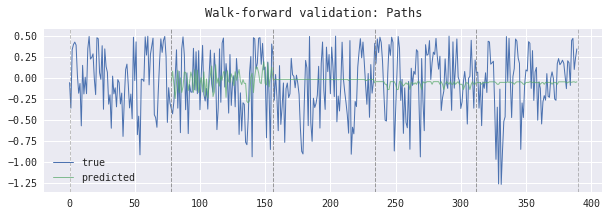

In [151]:
# -- Test run
test_mae_df, test_mse_df = experiment(
    n_iter=1,
    n_points=n_points,
    n_warmup=n_warmup,
    data_fun=data_fun,
    n_shifts=n_shifts,
    model=model,
    k_folds=k_folds,
    cv_fun=cv_fun,
    verbose=True,
)


MAE:


mean    std
0    NaN    NaN
1  0.325  0.036
2  0.313  0.032
3  0.309  0.034
4  0.306  0.033

MSE:


mean    std
1  0.159  0.037
2  0.146  0.029
3  0.142  0.033
4  0.141  0.033

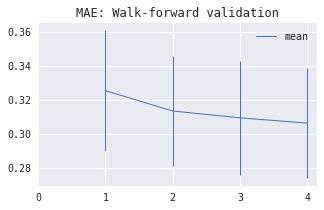

In [152]:
test_mae_df, test_mse_df = experiment(
    n_iter=n_iter,
    n_points=n_points,
    n_warmup=n_warmup,
    data_fun=data_fun,
    n_shifts=n_shifts,
    model=model,
    k_folds=k_folds,
    cv_fun=cv_fun,
    verbose=False,
)

show_results(test_mae_df, test_mse_df, cv_title)

### Moving-origin Forward Validation

In [153]:
cv_fun = partial(walk_forward, unbounded_fold=True)
cv_title = "Moving-origin Forward validation"

In [154]:
# -- Test run
test_mae_df, test_mse_df = experiment(
    n_iter=1,
    n_points=n_points,
    n_warmup=n_warmup,
    data_fun=data_fun,
    n_shifts=n_shifts,
    model=model,
    k_folds=k_folds,
    cv_fun=cv_fun,
    verbose=True,
)

2023-09-29T08:47:26.569346+0200 DEBUG 62: fold=0 coef=None mae_test=nan
2023-09-29T08:47:26.581916+0200 DEBUG 62: fold=1 coef=None mae_test=0.301
2023-09-29T08:47:26.586716+0200 DEBUG 62: fold=2 coef=None mae_test=0.297
2023-09-29T08:47:26.591945+0200 DEBUG 62: fold=3 coef=None mae_test=0.295
2023-09-29T08:47:26.595821+0200 DEBUG 62: fold=4 coef=None mae_test=0.285


MAE:


mean    std
0    NaN    NaN
1  0.318  0.018
2  0.312  0.020
3  0.308  0.023
4  0.306  0.033

MSE:


mean    std
1  0.152  0.018
2  0.145  0.018
3  0.142  0.023
4  0.141  0.033

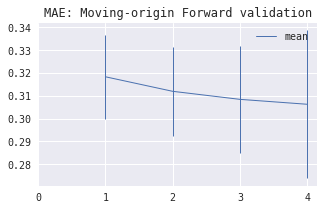

In [155]:
test_mae_df, test_mse_df = experiment(
    n_iter=n_iter,
    n_points=n_points,
    n_warmup=n_warmup,
    data_fun=data_fun,
    n_shifts=n_shifts,
    model=model,
    k_folds=k_folds,
    cv_fun=cv_fun,
    verbose=False,
)

show_results(test_mae_df, test_mse_df, cv_title)

### Blocked K-Fold CV

In [156]:
cv_fun = blocked_cv
cv_title = "Blocked K-fold CV"

2023-09-29T08:47:30.251444+0200 DEBUG 28: fold=0 coef=None mae_test=0.281
2023-09-29T08:47:30.267012+0200 DEBUG 28: fold=1 coef=None mae_test=0.324
2023-09-29T08:47:30.280031+0200 DEBUG 28: fold=2 coef=None mae_test=0.304
2023-09-29T08:47:30.289043+0200 DEBUG 28: fold=3 coef=None mae_test=0.311
2023-09-29T08:47:30.293546+0200 DEBUG 28: fold=4 coef=None mae_test=0.285


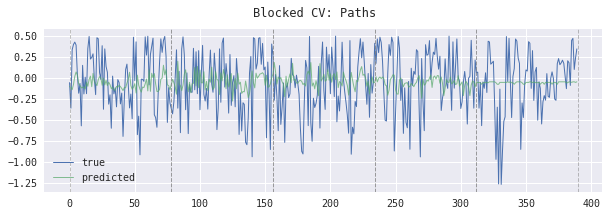

In [157]:
# -- Test run
test_mae_df, test_mse_df = experiment(
    n_iter=1,
    n_points=n_points,
    n_warmup=n_warmup,
    data_fun=data_fun,
    n_shifts=n_shifts,
    model=model,
    k_folds=k_folds,
    cv_fun=cv_fun,
    verbose=True,
)


MAE:


mean    std
0  0.307  0.033
1  0.316  0.036
2  0.309  0.032
3  0.308  0.034
4  0.306  0.033

MSE:


mean    std
0  0.141  0.031
1  0.149  0.037
2  0.142  0.029
3  0.141  0.034
4  0.141  0.033

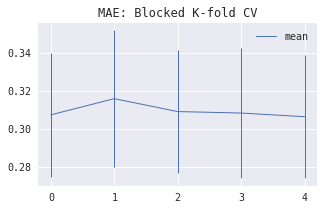

In [158]:
test_mae_df, test_mse_df = experiment(
    n_iter=n_iter,
    n_points=n_points,
    n_warmup=n_warmup,
    data_fun=data_fun,
    n_shifts=n_shifts,
    model=model,
    k_folds=k_folds,
    cv_fun=cv_fun,
    verbose=False,
)

show_results(test_mae_df, test_mse_df, cv_title)

### Combinatorial Purged CV

In [159]:
cv_fun = combinatorial_cv
cv_title = "Combinatorial CV"

2023-09-29T08:47:35.580865+0200 DEBUG 48: fold=(0, 1) coef=None mae_test=0.296
2023-09-29T08:47:35.592312+0200 DEBUG 48: fold=(0, 2) coef=None mae_test=0.293
2023-09-29T08:47:35.598982+0200 DEBUG 48: fold=(0, 3) coef=None mae_test=0.312
2023-09-29T08:47:35.604926+0200 DEBUG 48: fold=(0, 4) coef=None mae_test=0.291
2023-09-29T08:47:35.615744+0200 DEBUG 48: fold=(1, 2) coef=None mae_test=0.308
2023-09-29T08:47:35.626668+0200 DEBUG 48: fold=(1, 3) coef=None mae_test=0.313
2023-09-29T08:47:35.634154+0200 DEBUG 48: fold=(1, 4) coef=None mae_test=0.290
2023-09-29T08:47:35.647065+0200 DEBUG 48: fold=(2, 3) coef=None mae_test=0.304
2023-09-29T08:47:35.653391+0200 DEBUG 48: fold=(2, 4) coef=None mae_test=0.287
2023-09-29T08:47:35.659005+0200 DEBUG 48: fold=(3, 4) coef=None mae_test=0.295


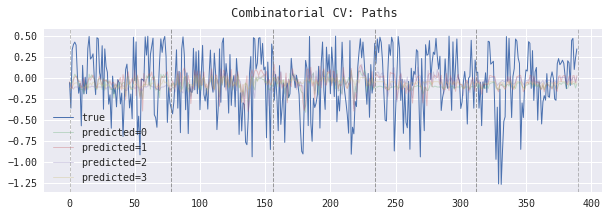

In [160]:
test_mae_df, test_mse_df = experiment(
    n_iter=1,
    n_points=n_points,
    n_warmup=n_warmup,
    data_fun=data_fun,
    n_shifts=n_shifts,
    model=model,
    k_folds=k_folds,
    cv_fun=cv_fun,
    verbose=True,
)

MAE:


mean    std
0  0.307  0.033
1  0.315  0.036
2  0.308  0.032
3  0.307  0.033
4  0.306  0.032

MSE:


mean    std
0  0.141  0.031
1  0.149  0.036
2  0.141  0.029
3  0.140  0.034
4  0.141  0.033

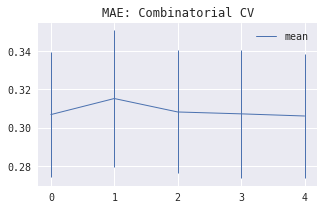

In [161]:
test_mae_df, test_mse_df = experiment(
    n_iter=n_iter,
    n_points=n_points,
    n_warmup=n_warmup,
    data_fun=data_fun,
    n_shifts=n_shifts,
    model=model,
    k_folds=k_folds,
    cv_fun=cv_fun,
    verbose=False,
)

show_results(test_mae_df, test_mse_df, "Combinatorial CV")

## Conclusion

### The main results

**For stationary time series, it's okay to use CV:**
- Cross-validation in time series introduces a look-ahead bias. However, for stationary time series, this isn't a big problem. Stationarity makes all time regions equally important for evaluation of (pretty much) any kind of statistics of a time series.
- In particular, the model error estimate will not be optimistic (i.e., not lower than the real error).
- At the same time, the variance of the model error estimate will be lower if compared to forward validation, which can be a big advantage.
- Extra reading: the papers [Bergmeir2012] and [Bergmeir2018] also advocate the use of cross-validation for stationary time series.

**For non-stationary time series with a mean drift, CV may give optimistic results:**
- Cross-validation can produce an optimistic estimate of model error for non-stationary time series. In particular, experiments 1 and 3 show a lower estimated error for the fold in the middle.
- Here, this issue was especially prominent for models with an intercept (this includes Gradient Boosted Trees models which have an implicit "intercept" term). In experiments 1 and 3 above, the time series local mean could shift significantly due to non-stationarity. The information about the mean drift can be learned by an intercept term more efficiently in the middle fold: there it becomes a problem of interpolation rather than extrapolation. Hence, we will get an optimistic bias of a model error estimate.
- Extra reading: the paper [Schnaubelt2019] finds that the use of cross-validation for non-stationary time series can produce model error estimates with higher bias and variance if compared to forward validation.

### References
- [Bergmeir2012] Bergmeir, C., Benítez, J.M., 2012. On the use of cross-validation for time series predictor evaluation.
- [Bergmeir2018] Bergmeir, C., et al., 2018. A note on the validity of cross-validation for evaluating autoregressive time series prediction.
- [Schnaubelt2019] Schnaubelt, M., 2019. A comparison of machine learning model validation schemes for non-stationary time series data.

### TODO
- An experiment with deterministic or stochastic change of ARMA coefficient over time
- An experiment with deterministic or stochastic appearence of new dependencies in data over time
- An experiment with Seasonal-Trend Decomposition or State Space models
- The impact of embargoing and purging

In [162]:
# --- The end ---